## Load data

In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons
from pymutspec.io import read_genbank_ref

from scipy.spatial.distance import euclidean, cityblock, pdist, squareform
from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error, r2_score
import tqdm
import pingouin as pg

from utils import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities, plot_exp_heatmap,
    prepare_aa_subst, plot_aa_eq_freqs, prepare_exp_aa_subst,
    calc_metrics,weighted_average_percentage_error, get_equilibrium_freqs
)

In [2]:
coda = CodonAnnotation(1)

In [3]:
aa_freqs_total_dct = pd.read_json('./data/ref_aa_freqs_mean.json', orient='index')[0].to_dict()
aa_freqs_total_dct

{'Arg': 350,
 'Val': 782,
 'Cys': 296,
 'Gly': 577,
 'Ser': 661,
 'Ala': 659,
 'Leu': 930,
 'Thr': 718,
 'Pro': 394,
 'Asp': 511,
 'Tyr': 448,
 'Phe': 501,
 'Ile': 513,
 'Asn': 532,
 'Lys': 562,
 'Gln': 365,
 'Glu': 442,
 'His': 189,
 'Met': 207,
 'Trp': 111}

In [4]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_24A = clades_spectra[clades_spectra['clade'] == '24A'].copy()
spectrum_24A['rate'] /= spectrum_24A['rate'].sum()

_clades_order = clades_spectra.drop_duplicates(subset='clade').set_index('clade')

_1 = {x:'Early clades' for x in _clades_order.loc[:'21J'].index.unique()}
_2 = {x:'Late clades\n(Omicron+)' for x in _clades_order.loc['21K':].index.unique()}

_clade2label = {**_1, **_2}
_clade2label

{'20A': 'Early clades',
 '20B': 'Early clades',
 '20C': 'Early clades',
 '20E': 'Early clades',
 '20G': 'Early clades',
 '20I': 'Early clades',
 '20J': 'Early clades',
 '21C': 'Early clades',
 '21I': 'Early clades',
 '21J': 'Early clades',
 '21K': 'Late clades\n(Omicron+)',
 '21L': 'Late clades\n(Omicron+)',
 '22A': 'Late clades\n(Omicron+)',
 '22B': 'Late clades\n(Omicron+)',
 '22C': 'Late clades\n(Omicron+)',
 '22D': 'Late clades\n(Omicron+)',
 '22E': 'Late clades\n(Omicron+)',
 '22F': 'Late clades\n(Omicron+)',
 '23A': 'Late clades\n(Omicron+)',
 '23B': 'Late clades\n(Omicron+)',
 '23C': 'Late clades\n(Omicron+)',
 '23D': 'Late clades\n(Omicron+)',
 '23F': 'Late clades\n(Omicron+)',
 '24A': 'Late clades\n(Omicron+)'}

In [5]:
aamut_fitness = pd.read_csv('./data/bloom_etal/aamut_fitness_by_clade.csv')
aamut_fitness['aa1'] = aamut_fitness['aa_mutation'].str[0]
aamut_fitness['aa2'] = aamut_fitness['aa_mutation'].str[-1]
aamut_fitness['time_period'] = aamut_fitness.clade.map(_clade2label)
aamut_fitness_ns = aamut_fitness.query('aa1 != aa2 & aa1 != "*" & aa2 != "*"')
aamut_fitness_ns

,clade,gene,clade_founder_aa,mutant_aa,aa_site,aa_mutation,expected_count,actual_count,count_terminal,count_non_terminal,mean_log_size,subset_of_ORF1ab,delta_fitness,aa1,aa2,time_period
4,20A,E,A,D,22,A22D,0.67725,0,0,0,0.0,False,-0.85633,A,D,Early clades
5,20A,E,A,D,32,A32D,0.67725,0,0,0,0.0,False,-0.85633,A,D,Early clades
6,20A,E,A,E,36,A36E,0.67725,0,0,0,0.0,False,-0.85633,A,E,Early clades
7,20A,E,A,E,41,A41E,0.67725,0,0,0,0.0,False,-0.85633,A,E,Early clades
8,20A,E,A,G,22,A22G,0.23810,0,0,0,0.0,False,-0.38947,A,G,Early clades
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2893364,24A,nsp1,Y,D,97,Y97D,0.25363,0,0,0,0.0,True,-0.41029,Y,D,Late clades\n(Omicron+)
2893365,24A,nsp1,Y,F,97,Y97F,0.77908,0,0,0,0.0,True,-0.93929,Y,F,Late clades\n(Omicron+)
2893366,24A,nsp1,Y,H,97,Y97H,2.17910,0,0,0,0.0,True,-1.67860,Y,H,Late clades\n(Omicron+)
2893367,24A,nsp1,Y,N,97,Y97N,0.48805,0,0,0,0.0,True,-0.68113,Y,N,Late clades\n(Omicron+)


## Delta Fitness of substitutions

### Explore variability of mutations delta fitneses in clades

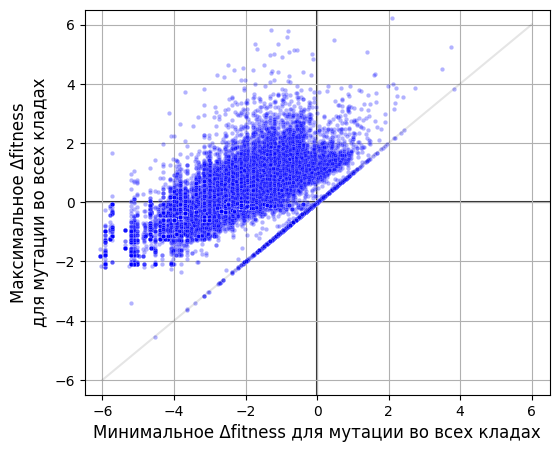

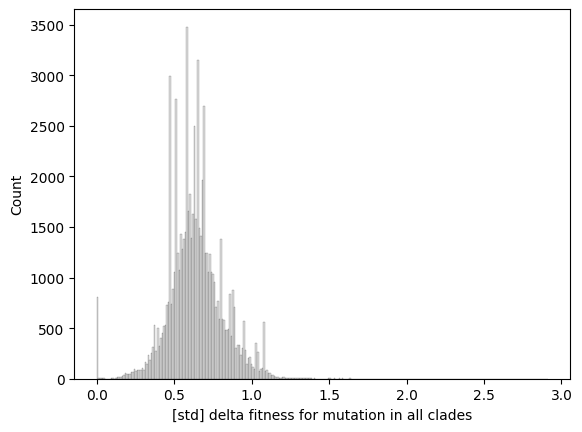

In [17]:
_ = aamut_fitness.query('subset_of_ORF1ab == False')\
    .groupby(['gene', 'aa_mutation'])['delta_fitness'].agg(['min', 'std', 'max'])
# _ = aamut_fitness.query('subset_of_ORF1ab == False')\
#     .groupby(['gene', 'aa_mutation', 'time_period'])['delta_fitness'].agg(['min', 'std', 'max'])


plt.figure(figsize=(6, 5))
ax = sns.scatterplot(_, x='min', y='max', s=10, alpha=0.3, color="blue")
plt.plot([-6, 6], [-6, 6], 'k-', alpha=0.1)
plt.ylabel('Максимальное Δfitness\nдля мутации во всех кладах', fontsize=12)
plt.xlabel('Минимальное Δfitness для мутации во всех кладах', fontsize=12)
plt.grid()
ax.set_axisbelow(True)
ax.vlines(0, -6.5, 6.5, 'k', zorder=0, alpha=0.8)
ax.hlines(0, -6.5, 6.5, 'k', zorder=0, alpha=0.8)
ax.set_xlim(-6.5, 6.5)
ax.set_ylim(-6.5, 6.5)
plt.show()

# sns.histplot(_['max']-_['min'], color='lightgray')
# plt.xlabel('[max - min] delta fitness for mutation in all clades');
# plt.show()

sns.histplot(_['std'].fillna(0), color='lightgray')
plt.xlabel('[std] delta fitness for mutation in all clades');
plt.show()

<Axes: >

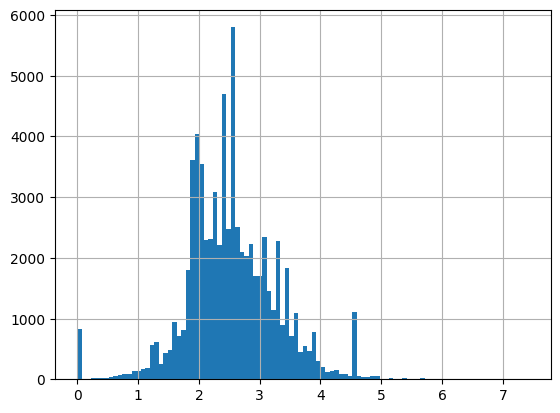

In [55]:
_['diff_min_max'] = _['max'] - _['min']
_.diff_min_max.hist(bins=100)

In [ ]:
# num of mutations on diagonal (y=x)
np.isclose(_.diff_min_max, 0, atol=1e-2).sum()

np.int64(810)

In [ ]:
# these mutations
_[np.isclose(_.diff_min_max, 0, atol=1e-2)]

min  std       max  diff_min_max
gene aa_mutation                                       
M    A30A         0.449860  NaN  0.449860           0.0
     A30E        -0.210690  NaN -0.210690           0.0
     A30G        -0.374020  NaN -0.374020           0.0
     A30P        -0.755280  NaN -0.755280           0.0
     A30S        -1.029400  NaN -1.029400           0.0
...                    ...  ...       ...           ...
S    Y138F        0.890770  NaN  0.890770           0.0
     Y138H       -0.503690  NaN -0.503690           0.0
     Y138N       -0.177560  NaN -0.177560           0.0
     Y138S       -0.086873  NaN -0.086873           0.0
     Y138Y        1.105700  NaN  1.105700           0.0

[810 rows x 4 columns]

In [71]:
_[_['min'].lt(0) & _['max'].gt(0)]

min       std       max  diff_min_max
gene aa_mutation                                           
E    A11A        -0.60487  0.317115  0.122520      0.727390
     A22A        -2.23060  0.579834  0.087748      2.318348
     A22G        -2.48090  0.679405  0.132800      2.613700
     A32A        -0.88602  0.447873  1.210600      2.096620
     A32P        -2.73940  0.661198  0.124680      2.864080
...                   ...       ...       ...           ...
S    Y904Y       -1.49490  0.673130  1.265500      2.760400
     Y917F       -2.02910  0.462677  0.252130      2.281230
     Y917Y       -0.94610  0.524586  1.155400      2.101500
     Y91F        -2.02910  0.557057  0.425960      2.455060
     Y91Y        -1.16770  0.654412  1.442200      2.609900

[37861 rows x 4 columns]

In [72]:
37861 / len(_) * 100

52.970227768761546

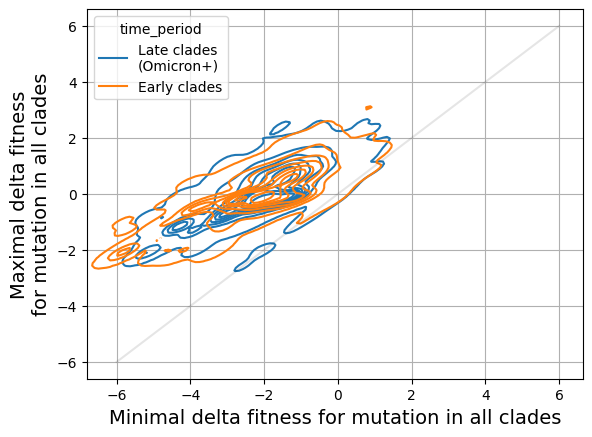

In [ ]:
# early and late clades have same distributions
sns.kdeplot(_.sample(10000), x='min', y='max', hue='time_period', 
            gridsize=100, levels=9, thresh=0.01)
plt.plot([-6, 6], [-6, 6], 'k-', alpha=0.1)
plt.ylabel('Maximal delta fitness\nfor mutation in all clades', fontsize=14)
plt.xlabel('Minimal delta fitness for mutation in all clades', fontsize=14)
plt.grid()
ax.set_axisbelow(True)
ax.vlines(0, -6.5, 6.5, 'k', zorder=0, alpha=0.8)
ax.hlines(0, -6.5, 6.5, 'k', zorder=0, alpha=0.8)
ax.set_xlim(-6.5, 6.5)
ax.set_ylim(-6.5, 6.5)
plt.show()

In [19]:
_clades_df = aamut_fitness.query('subset_of_ORF1ab == False')\
    .pivot(index=['gene', 'aa_mutation'], columns='clade', values='delta_fitness')
_clades_df

clade                 20A      20B      20C      20E      20G       20I  \
gene aa_mutation                                                          
E    A11A             NaN      NaN      NaN      NaN      NaN       NaN   
     A11E             NaN      NaN      NaN      NaN      NaN       NaN   
     A11G             NaN      NaN      NaN      NaN      NaN       NaN   
     A11P             NaN      NaN      NaN      NaN      NaN       NaN   
     A11S             NaN      NaN      NaN      NaN      NaN       NaN   
...                   ...      ...      ...      ...      ...       ...   
S    Y91F        -0.67699 -0.59596 -0.55808 -0.41476 -0.59817 -1.343000   
     Y91H        -1.31310 -1.19430 -1.16770 -0.95033 -1.13110 -2.250500   
     Y91N        -0.46773 -0.39687 -0.45832 -0.32602 -0.41692 -1.106100   
     Y91S        -0.40684 -0.27338 -0.27589 -0.22215 -0.26856 -0.778240   
     Y91Y         0.29636  1.00290 -1.16770  0.14828  0.81483 -0.053288   

clade                  20J      21C      21I      21J  ...      22C      22D  \
gene aa_mutation                                       ...                     
E    A11A              NaN      NaN      NaN      NaN  ...      NaN      NaN   
     A11E              NaN      NaN      NaN      NaN  ...      NaN      NaN   
     A11G              NaN      NaN      NaN      NaN  ...      NaN      NaN   
     A11P              NaN      NaN      NaN      NaN  ...      NaN      NaN   
     A11S              NaN      NaN      NaN      NaN  ...      NaN      NaN   
...                    ...      ...      ...      ...  ...      ...      ...   
S    Y91F        -0.207840 -0.31746 -0.85084 -0.22744  ... -0.63677 -0.29653   
     Y91H        -0.503690 -0.68046 -1.55270 -1.44440  ... -1.49490 -0.94610   
     Y91N        -0.177560 -0.20449 -0.49139 -1.02800  ... -0.54343 -0.26218   
     Y91S        -0.086873 -0.13240 -0.46096 -2.11990  ... -0.28748 -0.13714   
     Y91Y         1.442200 -0.68046 -0.45409  0.77279  ... -0.39627 -0.94610   

clade                 22E       22F       23A       23B       23C       23D  \
gene aa_mutation                                                              
E    A11A             NaN  0.106410 -0.188840 -0.604870  0.122520 -0.566980   
     A11E             NaN -0.665130 -1.551500 -0.855930 -0.465520 -0.833460   
     A11G             NaN -0.065541 -0.392910 -0.161270 -0.068992 -0.120750   
     A11P             NaN -0.295890 -0.862870 -0.450640 -0.232560 -0.389470   
     A11S             NaN -1.449300 -1.715500 -0.858660 -0.054236 -0.313170   
...                   ...       ...       ...       ...       ...       ...   
S    Y91F        -1.02280 -0.366200  0.050248 -0.477600 -0.257520 -0.518400   
     Y91H        -1.99630 -0.893180 -2.029000 -1.189600 -0.810930 -1.116800   
     Y91N        -0.96149 -0.235060 -0.701530 -0.314140 -0.228380 -0.333800   
     Y91S        -0.48004 -0.166800 -0.538510 -0.219840 -0.094410 -0.237270   
     Y91Y         0.20089 -0.893180  0.368880 -0.090998 -0.810930 -0.018233   

clade                 23F      24A  
gene aa_mutation                    
E    A11A        -0.11870      NaN  
     A11E        -0.98173      NaN  
     A11G        -0.18764      NaN  
     A11P        -0.57308      NaN  
     A11S        -0.60149      NaN  
...                   ...      ...  
S    Y91F         0.42596  0.15932  
     Y91H        -1.40610 -0.58002  
     Y91N        -0.45437 -0.68113  
     Y91S        -0.30960 -0.34281  
     Y91Y        -0.30748 -0.58002  

[71476 rows x 24 columns]

In [10]:
_clades_df.loc[('S', 'Y91F')].describe()

count    24.000000
mean     -0.574870
std       0.557057
min      -2.029100
25%      -0.679450
50%      -0.512465
75%      -0.286778
max       0.425960
Name: (S, Y91F), dtype: float64

In [16]:
_clades_df.columns[:11]

Index(['20A', '20B', '20C', '20E', '20G', '20I', '20J', '21C', '21I', '21J',
       '21K'],
      dtype='object', name='clade')

In [11]:
_d = []
for _, x in _clades_df.iterrows():
    _d.append([x.argmin() < 10, x.argmax() < 10])

In [12]:
pd.DataFrame(_d)[0].value_counts()

0
True     36705
False    34771
Name: count, dtype: int64

In [13]:
pd.DataFrame(_d)[1].value_counts()

1
True     38614
False    32862
Name: count, dtype: int64

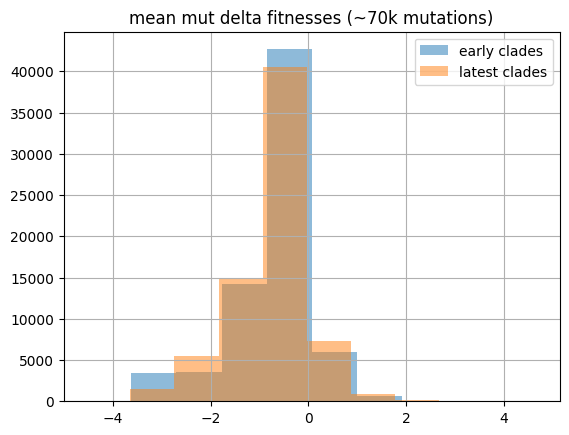

In [12]:
_clades_df.iloc[:, :10].mean(axis=1).hist(alpha=0.5, label='early clades')
_clades_df.iloc[:, 10:].mean(axis=1).hist(alpha=0.5, label='latest clades')
plt.title('mean mut delta fitnesses (~70k mutations)')
plt.legend()

In [15]:
_clades_df.iloc[:, :10].std(axis=1)

gene  aa_mutation
E     A11A                NaN
      A11E                NaN
      A11G                NaN
      A11P                NaN
      A11S                NaN
                       ...   
S     Y91F           0.337478
      Y91H           0.485324
      Y91N           0.314034
      Y91S           0.600905
      Y91Y           0.819356
Length: 71476, dtype: float64

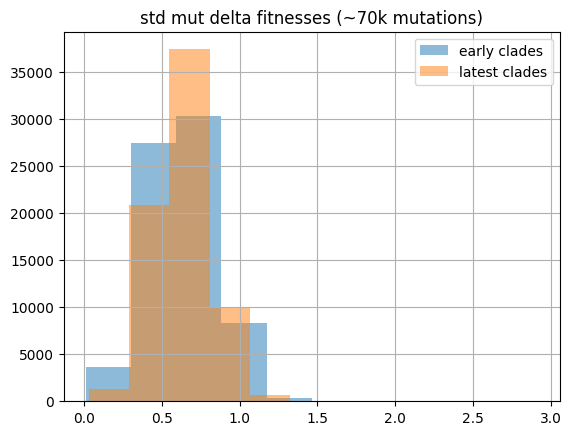

In [16]:
_clades_df.iloc[:, :10].std(axis=1).hist(alpha=0.5, label='early clades')
_clades_df.iloc[:, 10:].std(axis=1).hist(alpha=0.5, label='latest clades')
plt.title('std mut delta fitnesses (~70k mutations)')
plt.legend()

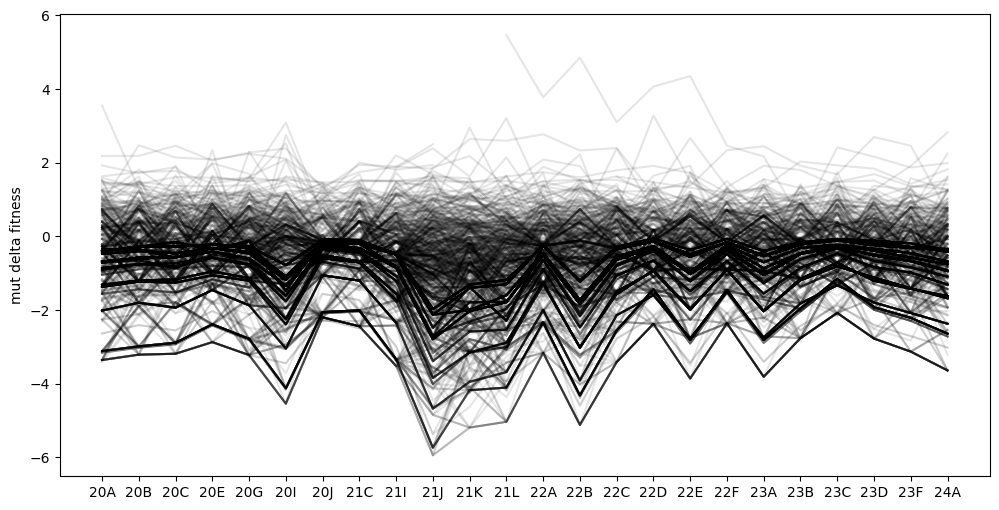

In [15]:
plt.figure(figsize=(12, 6))

plt.ylabel('mut delta fitness')
for _, x in _clades_df.sample(1000, replace=False).iterrows():
    plt.plot(x, color='k', alpha=0.1)

/tmp/ipykernel_33996/397310978.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(_clades_df.iloc[random.randint(0, len(_clades_df-1))].values, alpha=.5)
/tmp/ipykernel_33996/397310978.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='100 случайных мутаций', fontsize=14)


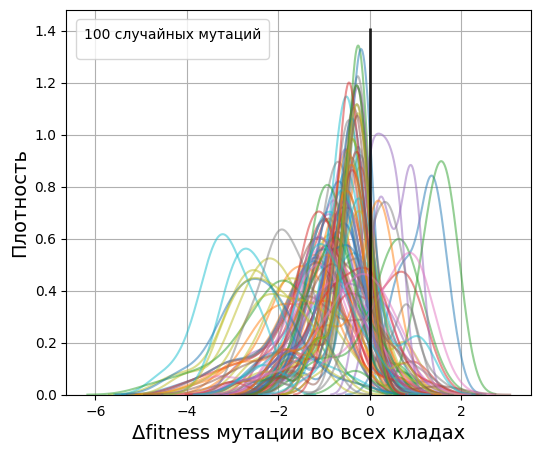

In [24]:
import random

random.seed(420)

plt.figure(figsize=(6, 5))

for i in range(100):
    ax = sns.kdeplot(_clades_df.iloc[random.randint(0, len(_clades_df-1))].values, alpha=.5)

ax.vlines(0, 0, ax.get_ylim()[1], 'k', alpha=0.85, linewidth=2)

plt.grid()
ax.set_axisbelow(True)
plt.xlabel('Δfitness мутации во всех кладах', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.legend(title='100 случайных мутаций', fontsize=14)

### Rate cats

In [6]:
from Bio import SeqIO

from typing import Union
from Bio.SeqRecord import SeqRecord

def read_genbank_ref(gb: Union[str, SeqRecord]):
    if isinstance(gb, str):
        genome = next(SeqIO.parse(gb, "genbank"))
    elif isinstance(gb, SeqRecord):
        genome = gb
    else:
        raise NotImplementedError

    ftypes = {"CDS", "rRNA", "tRNA"}
    full_nucls = set("ACGT")
    data = []
    df: pd.DataFrame = None
    gene_qualifier = None
    for ftr in genome.features:
        if ftr.type == "source":
            source = ftr.extract(genome)
            seq = str(source.seq)
            for pos, nuc in enumerate(seq):
                context = seq[pos - 1: pos + 2]
                if len(context) < 3 or len(set(context).difference(full_nucls)) != 0:
                    context = None
                if nuc not in full_nucls:
                    nuc = context = None
                data.append({"Pos": pos + 1, "Nuc": nuc, "Context": context})
            df = pd.DataFrame(data)
            df["Strand"] = 0
            continue
        elif gene_qualifier is None and ftr.type in ftypes:
            for qualifier in ["gene", "product", "protein_id"]:
                if qualifier in ftr.qualifiers:
                    gene_qualifier = qualifier
                    break
            if gene_qualifier is None:
                raise RuntimeError(f"Cannot find any expected qualifier of feature: {ftr}; with following qualifiers: {ftr.qualifiers}")

        for pos in list(ftr.location):
            df.at[pos, "Type"] = ftr.type
            df.at[pos, "Strand"] = ftr.location.strand
            if ftr.type in ftypes:
                df.at[pos, qualifier] = ftr.qualifiers[qualifier][0]

    # add codon features
    df["PosInGene"] = -1
    df["PosInCodon"] = -1
    for gene_name in df[(df.Type == "CDS") & (df.Strand == 1)][gene_qualifier].unique():
        gdf = df[df[gene_qualifier] == gene_name]
        seq = gdf.Nuc.values
        for pos_in_gene, pos in enumerate(gdf.index):
            pic = pos_in_gene % 3
            cdn = seq[pos_in_gene - pic: pos_in_gene - pic + 3]
            cdn = "".join(cdn) if len(set(cdn).difference(full_nucls)) == 0 else None
            df.at[pos, "Codon"] = cdn
            df.at[pos, "PosInGene"] = pos_in_gene + 1
            df.at[pos, "PosInCodon"] = pic + 1

    df["Strand"] = df["Strand"].astype(np.int8)
    df["PosInCodon"] = df["PosInCodon"].astype(np.int8)
    df["PosInGene"] = df["PosInGene"].astype(np.int32)
    return df


In [7]:
ref_sites_df = read_genbank_ref('data/NC_045512.2.gb')
ref_sites_df = ref_sites_df[ref_sites_df.Codon.notna()]
# Pos and nt_site is the same
ref_sites_df

,Pos,Nuc,Context,Strand,Type,gene,PosInGene,PosInCodon,Codon
265,266,A,GAT,1,mat_peptide,ORF1ab,1,1,ATG
266,267,T,ATG,1,mat_peptide,ORF1ab,2,2,ATG
267,268,G,TGG,1,mat_peptide,ORF1ab,3,3,ATG
268,269,G,GGA,1,mat_peptide,ORF1ab,4,1,GAG
269,270,A,GAG,1,mat_peptide,ORF1ab,5,2,GAG
...,...,...,...,...,...,...,...,...,...
29669,29670,C,ACA,1,CDS,ORF10,113,2,ACA
29670,29671,A,CAT,1,CDS,ORF10,114,3,ACA
29671,29672,T,ATA,1,CDS,ORF10,115,1,TAG
29672,29673,A,TAG,1,CDS,ORF10,116,2,TAG


In [8]:
from utils import categorize_site_rates_robust_plus_invariant

_cnt1 = aamut_fitness_ns.query('subset_of_ORF1ab == False')\
    .groupby(['clade', 'gene','aa_site'])['actual_count'].sum().rename('MutCountNonsyn').reset_index()
ref_sites_df_clades = ref_sites_df.rename(columns={'PosInGene':'aa_site'}).merge(_cnt1)
ref_sites_df_clades['MutCountNonsyn'].fillna(0, inplace=True)
ref_sites_df_clades['AA'] = ref_sites_df_clades['Codon'].apply(coda.translate_codon).map(amino_acid_codes)

data = []
for clade in aamut_fitness_ns.clade.unique():
    cur_ref_sites_df = ref_sites_df_clades.query('clade == @clade').copy()
    categories, rates, alpha = categorize_site_rates_robust_plus_invariant(
        cur_ref_sites_df['MutCountNonsyn'], 6, 99, plot=False, verbose=False)
    cur_ref_sites_df['rate_cat_ns'] = categories
    data.append(cur_ref_sites_df)

ref_sites_df_clades_cat = pd.concat(data, axis=0)
ref_sites_df_clades_cat

/tmp/ipykernel_33996/949152805.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ref_sites_df_clades['MutCountNonsyn'].fillna(0, inplace=True)


,Pos,Nuc,Context,Strand,Type,gene,aa_site,PosInCodon,Codon,clade,MutCountNonsyn,AA,rate_cat_ns
0,266,A,GAT,1,mat_peptide,ORF1ab,1,1,ATG,20A,0,Met,0
24,267,T,ATG,1,mat_peptide,ORF1ab,2,2,ATG,20A,6,Met,3
48,268,G,TGG,1,mat_peptide,ORF1ab,3,3,ATG,20A,6,Met,3
72,269,G,GGA,1,mat_peptide,ORF1ab,4,1,GAG,20A,4,Glu,2
96,270,A,GAG,1,mat_peptide,ORF1ab,5,2,GAG,20A,4,Glu,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231124,29591,A,TAC,1,CDS,ORF10,34,1,ACG,24A,4,Thr,2
231148,29592,C,ACG,1,CDS,ORF10,35,2,ACG,24A,1,Thr,1
231172,29593,G,CGA,1,CDS,ORF10,36,3,ACG,24A,4,Thr,2
231196,29594,A,GAT,1,CDS,ORF10,37,1,ATA,24A,48,Ile,4


In [9]:
df = aamut_fitness_ns.query('subset_of_ORF1ab == False').merge(
    ref_sites_df_clades_cat[['clade', 'gene', 'aa_site', 'AA', 'rate_cat_ns']], 
    on=['clade', 'gene', 'aa_site']
)
df.groupby(['clade', 'rate_cat_ns'])['delta_fitness'].mean().unstack().T

clade,20A,20B,20C,20E,20G,20I,20J,21C,21I,21J,...,22C,22D,22E,22F,23A,23B,23C,23D,23F,24A
rate_cat_ns,,,,,,,,,,,,,,,,,,,,,
0,-1.133338,-1.026535,-1.048072,-0.820969,-1.004371,-1.989595,-0.556436,-0.631333,-1.337171,-3.427041,...,-1.148409,-0.692530,-1.538726,-0.686254,-1.501004,-0.874156,-0.565061,-0.876160,-1.067339,-1.309922
1,-0.891382,-0.831372,-0.818093,-0.636009,-0.729098,-1.584019,-0.395069,-0.463222,-1.053759,-2.584004,...,-0.886383,-0.513054,-1.193743,-0.507885,-1.188806,-0.691585,-0.388402,-0.683392,-0.803843,-1.034613
2,-0.662600,-0.650247,-0.624668,-0.507331,-0.589810,-1.116970,-0.321419,-0.361371,-0.800319,-1.616529,...,-0.664751,-0.405998,-0.886215,-0.402449,-0.889875,-0.539271,-0.291926,-0.539312,-0.614885,-0.813271
3,-0.540607,-0.478429,-0.494750,-0.379794,-0.448332,-0.823218,-0.241203,-0.264857,-0.605271,-1.171318,...,-0.498619,-0.303068,-0.656613,-0.306365,-0.646759,-0.405876,-0.189926,-0.390356,-0.487479,-0.605839
4,-0.310554,-0.255641,-0.257736,-0.195924,-0.218325,-0.592961,-0.073074,-0.067716,-0.370247,-0.802541,...,-0.262716,-0.126825,-0.372178,-0.106688,-0.344396,-0.192602,-0.007240,-0.184462,-0.233074,-0.356373
5,0.196658,0.219982,0.299181,0.149932,0.245662,0.104789,0.361094,0.289674,0.162611,-0.032283,...,0.214319,0.434820,0.293540,0.290557,0.248171,0.250814,0.349603,0.318270,0.421597,0.302491


In [10]:
df.query('rate_cat_ns == 0').actual_count.max()

np.int64(0)

<Axes: xlabel='rate_cat_ns', ylabel='delta_fitness'>

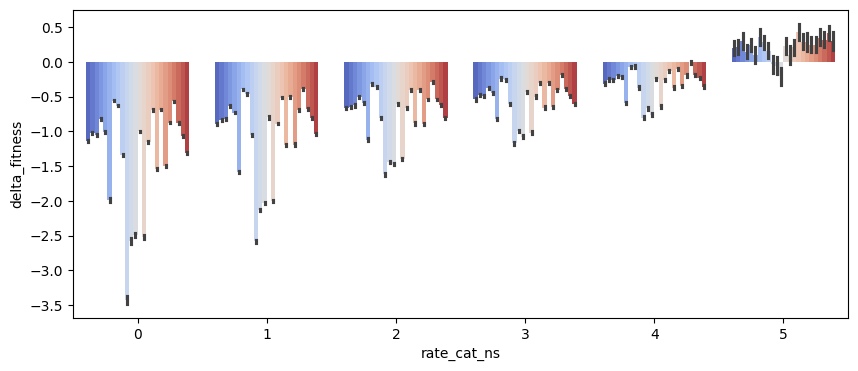

In [12]:
plt.figure(figsize=(10, 4))
sns.barplot(df,x='rate_cat_ns', y='delta_fitness', hue='clade', 
            legend=False, palette='coolwarm')


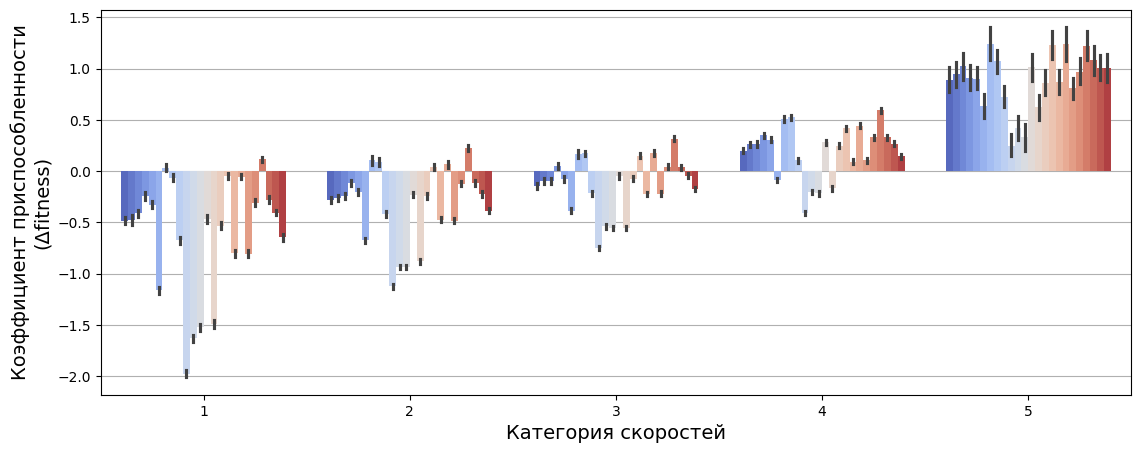

In [32]:
plt.figure(figsize=(13.3, 5))
ax= sns.barplot(df.query('actual_count > 0'), 
            x='rate_cat_ns', y='delta_fitness', hue='clade', 
            legend=False, palette='coolwarm')
plt.ylabel('Коэффициент приспособленности\n(Δfitness)', fontsize=14)
plt.xlabel('Категория скоростей', fontsize=14)
plt.grid(axis='y')
ax.set_axisbelow(True)

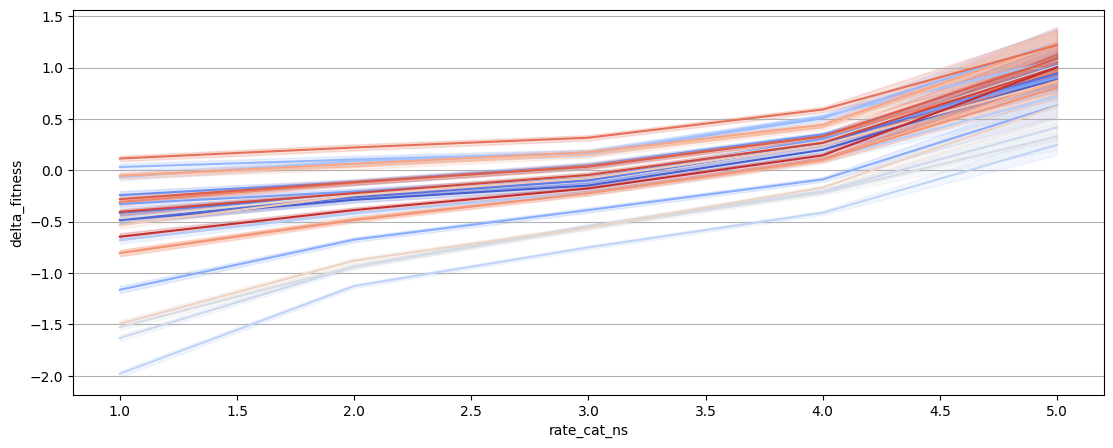

In [35]:
plt.figure(figsize=(13.3, 5))
ax= sns.lineplot(df.query('actual_count > 0'), 
            x='rate_cat_ns', y='delta_fitness', hue='clade', 
            legend=False, palette='coolwarm')
# plt.ylabel('Коэффициент приспособленности\n(Δfitness)', fontsize=14)
# plt.xlabel('Категория скоростей', fontsize=14)
plt.grid(axis='y')
# ax.set_axisbelow(True)

### asses model

In [10]:
aamut_fitness_ns.query('clade == "20A" & actual_count > 0 & delta_fitness < -0.5').actual_count.sum()

np.int64(17931)

In [178]:
aamut_fitness_ns.query('clade == "20A" & actual_count > 0 & delta_fitness < -3').actual_count.sum()

np.int64(0)

In [20]:
exp_aa_subst = prepare_exp_aa_subst(spectrum_20A)[0]
_ = aamut_fitness_ns.query('clade == "20A"').rename(columns={'actual_count': 'count'})
calc_metrics(prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct))

{'r2': 0.5569328034321411,
 'mape': 1.1288559426971851,
 'wape': 0.5933168090860368,
 'slope': np.float64(0.6507481373798778),
 'intercept': np.float64(0.0023283457508008116),
 'spearman_corr': np.float64(0.8080992321311243),
 'spearman_p': np.float64(7.748360438253803e-36),
 'pearson_corr': np.float64(0.7541575285816124),
 'pearson_corr_squared': np.float64(0.5687535779163256),
 'pearson_p': np.float64(8.056237431679284e-29),
 'ks_stat': np.float64(0.09333333333333334),
 'ks_p': np.float64(0.5321869291503776),
 'rmse': 0.00868497895993751,
 'log_likelihood': np.float64(-5.3123766538446),
 'mut_count': np.float64(103442.0),
 'mut_type_count': np.int64(149),
 'corr_chem_vs_rel_freq': np.float64(-0.25376405206229485),
 'corr_chem_vs_rel_freq_pval': np.float64(0.001727830794378172)}

In [38]:
_ = aamut_fitness_ns.query('clade == "20A" & delta_fitness > 1').rename(columns={'actual_count': 'count'})
calc_metrics(prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct))

{'r2': 0.30375293771826295,
 'mape': 1.7040397772954539,
 'wape': 0.7787976968780224,
 'slope': np.float64(0.5007883242720906),
 'intercept': np.float64(0.003328077838186062),
 'spearman_corr': np.float64(0.5711972158882765),
 'spearman_p': np.float64(2.2995088160392967e-14),
 'pearson_corr': np.float64(0.5994891590975107),
 'pearson_corr_squared': np.float64(0.35938725187544046),
 'pearson_p': np.float64(5.264401376540356e-16),
 'ks_stat': np.float64(0.13333333333333333),
 'ks_p': np.float64(0.13906219315479607),
 'rmse': 0.011245885612603184,
 'log_likelihood': np.float64(-5.609903776129842),
 'mut_count': np.float64(23058.0),
 'mut_type_count': np.int64(136),
 'corr_chem_vs_rel_freq': np.float64(-0.16804074070541314),
 'corr_chem_vs_rel_freq_pval': np.float64(0.0398313363673154)}

In [18]:
# aamut_fitness_ns[aamut_fitness_ns.delta_fitness < -5]
aamut_fitness_ns.query('actual_count > 0 & 3 < delta_fitness < 5')#.actual_count.sum()

,clade,gene,clade_founder_aa,mutant_aa,aa_site,aa_mutation,expected_count,actual_count,count_terminal,count_non_terminal,mean_log_size,subset_of_ORF1ab,delta_fitness,aa1,aa2
482,20A,E,V,L,75,V75L,0.516610,40,37,3,0.11304,False,3.6848,V,L
4121,20A,N,Q,K,7,Q7K,0.677250,29,18,11,0.57479,False,3.2212,Q,K
5846,20A,ORF1ab,A,D,1708,A1708D,0.677250,28,11,17,0.99626,False,3.1867,A,D
18216,20A,ORF1ab,F,V,536,F536V,0.216990,21,17,4,0.17064,False,3.4007,F,V
27916,20A,ORF1ab,K,R,3353,K3353R,1.463400,151,88,63,0.71918,False,4.3459,K,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2871314,20C,nsp12 (RdRp),Y,F,719,Y719F,0.373660,63,30,33,0.55822,True,4.2861,Y,F
2881956,22B,nsp14,Y,D,69,Y69D,1.171200,39,32,7,0.21734,True,3.1628,Y,D
2881972,22D,nsp14,Y,D,69,Y69D,0.073537,27,14,13,0.43757,True,3.8701,Y,D
2881988,22F,nsp14,Y,D,69,Y69D,0.082864,43,34,9,0.28278,True,4.3126,Y,D


In [39]:
print('delta fitness')
print('interval      r2')
# for mi,ma in zip([-5.] + np.linspace(-3, 5, 11).tolist(), np.linspace(-3, 5, 11).tolist() + [7.]):
# for mi,ma in zip([-2., -1, 0, 1, 2], [ -1, 0, 1, 2, 3]):
for mi,ma in zip(np.linspace(-2, 3, 11).tolist(), (np.linspace(-2, 3, 11)+0.5).tolist()):
    _ = aamut_fitness_ns.query(f'clade == "20A" & actual_count > 0 & {mi} < delta_fitness < {ma}').rename(columns={'actual_count': 'count'})
    if _['count'].sum() < 1000:
        continue
    aas = prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct)
    if aas.nobs.eq(0).sum() > 80:
        continue
    cur_metrics = calc_metrics(aas)
    print(f"[{mi:.1f}, {ma:.1f}]: {cur_metrics['r2']:.2f}")


delta fitness
interval      r2
[-0.5, 0.0]: 0.43
[0.0, 0.5]: 0.39
[0.5, 1.0]: 0.51
[1.0, 1.5]: 0.40
[1.5, 2.0]: 0.02


In [40]:
_ = aamut_fitness_ns.query(f'clade == "20A" & actual_count > 0 & delta_fitness < 0.05').rename(columns={'actual_count': 'count'})
calc_metrics(prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct))

{'r2': 0.6288778602493871,
 'mape': 1.1260260701521927,
 'wape': 0.5047886304409148,
 'slope': np.float64(0.6169671247594689),
 'intercept': np.float64(0.0025535525016035427),
 'spearman_corr': np.float64(0.8820458071570433),
 'spearman_p': np.float64(3.156359976702255e-50),
 'pearson_corr': np.float64(0.7931660147937304),
 'pearson_corr_squared': np.float64(0.6291123270237682),
 'pearson_p': np.float64(1.093851453985596e-33),
 'ks_stat': np.float64(0.5266666666666666),
 'ks_p': np.float64(2.2756141085163098e-19),
 'rmse': 0.008817497413342715,
 'log_likelihood': np.float64(-4.973663733729182),
 'mut_count': np.float64(34857.0),
 'mut_type_count': np.int64(71),
 'corr_chem_vs_rel_freq': np.float64(-0.23373378673327283),
 'corr_chem_vs_rel_freq_pval': np.float64(0.003993435821890804)}

In [41]:
clades_mut_cnt = aamut_fitness_ns.groupby('clade')['actual_count'].sum().sort_values()
clades_mut_cnt[clades_mut_cnt>100000]

clade
20A     103442
24A     105676
21I     132706
23A     149559
22E     150185
20I     335836
21L     502165
22B     543905
21K     627867
21J    1603754
Name: actual_count, dtype: int64

In [42]:
aamut_fitness_ns.query('clade == "21J" & not subset_of_ORF1ab')

,clade,gene,clade_founder_aa,mutant_aa,aa_site,aa_mutation,expected_count,actual_count,count_terminal,count_non_terminal,mean_log_size,subset_of_ORF1ab,delta_fitness,aa1,aa2
630824,21J,E,A,D,22,A22D,14.3280,0,0,0,0.00000,False,-3.38970,A,D
630825,21J,E,A,D,32,A32D,14.3280,0,0,0,0.00000,False,-3.38970,A,D
630826,21J,E,A,E,36,A36E,14.3280,0,0,0,0.00000,False,-3.38970,A,E
630827,21J,E,A,E,41,A41E,14.3280,0,0,0,0.00000,False,-3.38970,A,E
630828,21J,E,A,G,22,A22G,5.4762,0,0,0,0.00000,False,-2.48090,A,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700772,21J,S,Y,S,837,Y837S,3.6650,0,0,0,0.00000,False,-2.11990,Y,S
700773,21J,S,Y,S,873,Y873S,3.6650,0,0,0,0.00000,False,-2.11990,Y,S
700774,21J,S,Y,S,904,Y904S,3.6650,3,2,1,0.23105,False,-0.17395,Y,S
700775,21J,S,Y,S,91,Y91S,3.6650,0,0,0,0.00000,False,-2.11990,Y,S


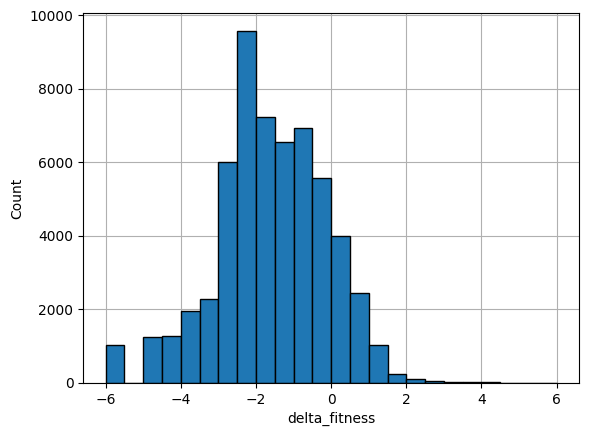

In [43]:
ax = sns.histplot(
    # aamut_fitness_ns.query('actual_count > 0'), 
    aamut_fitness_ns.query('clade == "21J" & not subset_of_ORF1ab'), 
    # weights='actual_count', 
    x='delta_fitness', 
    # hue='clade', hue_order=clades_mut_cnt[clades_mut_cnt>100000].index,
    # stat="density", common_norm=False, element="step", 
    binwidth=0.5, binrange=(-6, 6), alpha=1
)
plt.grid()
ax.set_axisbelow(True)

In [55]:
ax.get_yticks()[-1]

np.float64(250000.0)

Text(0, 0.5, 'observed mutations density')

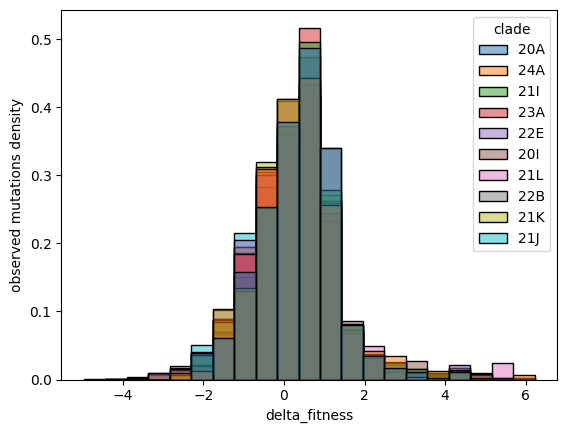

In [91]:
sns.histplot(
    aamut_fitness_ns.query('actual_count > 0'), 
    weights='actual_count', 
    x='delta_fitness', 
    hue='clade', hue_order=clades_mut_cnt[clades_mut_cnt>100000].index,
    stat="density", common_norm=False, 
    # element="step", 
    bins=21,
)
plt.ylabel('observed mutations density')

<Axes: xlabel='delta_fitness', ylabel='Density'>

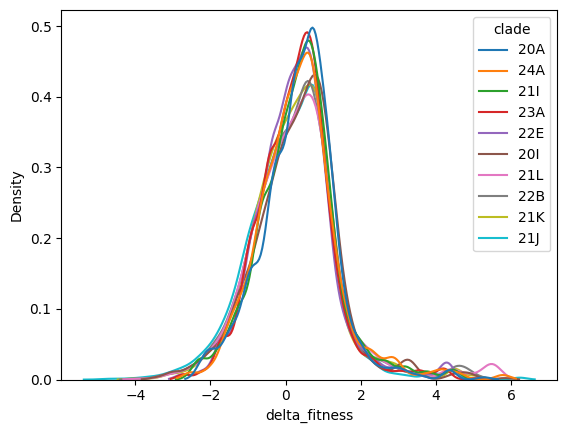

In [38]:
sns.kdeplot(aamut_fitness_ns.query('actual_count > 0'), 
             weights='actual_count', x='delta_fitness', common_norm=False,
             hue='clade', hue_order=clades_mut_cnt[clades_mut_cnt>100000].index)

### image for paper

In [6]:
clades_mut_cnt = aamut_fitness_ns.groupby('clade')['actual_count'].sum().sort_values()
clades_mut_cnt[clades_mut_cnt>100000]

clade
20A     103442
24A     105676
21I     132706
23A     149559
22E     150185
20I     335836
21L     502165
22B     543905
21K     627867
21J    1603754
Name: actual_count, dtype: int64

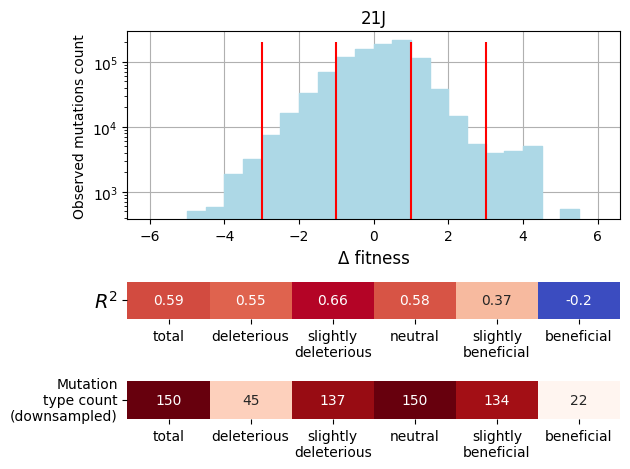

In [45]:
# clade = '24A'
clade = '21J'
downsample = False


spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
df_changes = collect_possible_changes(1, spectrum_dct)
exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
    .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

aamut_fitness_ns_clade = aamut_fitness_ns.query(
    'clade == @clade & not subset_of_ORF1ab & actual_count > 0')\
    .rename(columns={'actual_count': 'count'})
aas = prepare_aa_subst(aamut_fitness_ns_clade, exp_aa_subst_cur, aa_freqs_total_dct)
cur_met = calc_metrics(aas)
corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
mut_type_cnt = aas.nobs.ne(0).sum()
mut_cnt = aas.nobs.sum()

_data = []
_data.append(['total', cur_met['r2'], corrr, mut_cnt, mut_type_cnt])

# aa_muts_for_down = aamut_fitness_ns_clade[['aa1', 'aa2']]\
# aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness > 3')[['aa1', 'aa2']]\
aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness < -3')[['aa1', 'aa2']]\
    .drop_duplicates().reset_index(drop=True)

for (b1, b2), label in zip(
    [[-np.inf, -3], [-3, -1], [-1, 1], [1, 3], [3, np.inf]],
    ['deleterious', 'slightly deleterious', 'neutral', 'slightly beneficial', 'beneficial']
    ):
    cur_mut = aamut_fitness_ns_clade[aamut_fitness_ns_clade.delta_fitness.between(b1, b2, 'right')]

    if downsample:
        print('INFO: downsampling mutations for', label)
        cur_mut_down = cur_mut.merge(aa_muts_for_down)
        nmut = cur_mut['count'].sum()
        print(nmut, len(cur_mut_down))
        if nmut <= 500:
            print(f'WARNING: less than 500 {label} mutations ({nmut}) --> don\'t assess the model')
            _data.append([label, np.nan, np.nan, np.nan, np.nan])
            continue
        # elif nmut > 6110:
        elif len(cur_mut_down) > 10:
            cur_mut = cur_mut_down
        else:
            print(f'INFO: low number of {label} mutations')

    aas = prepare_aa_subst(cur_mut, exp_aa_subst_cur, aa_freqs_total_dct)
    cur_met = calc_metrics(aas)
    corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
    mut_type_cnt = aas.nobs.ne(0).sum()
    mut_cnt = aas.nobs.sum()
    _data.append([label, cur_met['r2'], corrr, mut_cnt, mut_type_cnt])

df_df_res = pd.DataFrame(
    _data, columns=['mut_sample', 'r2', 'spearman_corr', 'mut_cnt', 'mut_type_cnt']
)#.assign(clade=clade)

df_df_res_for_plot = df_df_res.copy()
df_df_res_for_plot['mut_sample'] = df_df_res_for_plot['mut_sample'].str.replace(' ', '\n')

fig, axs = plt.subplots(3, 1, height_ratios=[5, 1, 1])

ax = sns.histplot(
    # aamut_fitness_ns.query('actual_count > 0'), 
    aamut_fitness_ns.query('clade == @clade & not subset_of_ORF1ab'), 
    weights='actual_count', 
    x='delta_fitness', 
    # hue='clade', hue_order=clades_mut_cnt[clades_mut_cnt>100000].index,
    # stat="density", common_norm=False,
    element="step", 
    binwidth=0.5, binrange=(-6, 6), alpha=1, color='lightblue', ax=axs[0]
)
axs[0].grid()
axs[0].set_title(clade)
axs[0].vlines([-3, -1, 1, 3], 0, axs[0].get_yticks()[-2], 'red', linewidth=1.5)
axs[0].set_ylabel('Observed mutations count')
axs[0].set_xlabel('Δ fitness', fontsize=12)
axs[0].set_axisbelow(True)
axs[0].set_yscale('log')

sns.heatmap(df_df_res_for_plot.set_index('mut_sample')[['r2']].T, ax=axs[1],
            cmap='coolwarm', annot=True, cbar=False)
axs[1].set_xlabel('')
axs[1].set_yticklabels(['$R^2$'], rotation=0, fontsize=14)

sns.heatmap(df_df_res_for_plot.set_index('mut_sample')[['mut_type_cnt']].T, ax=axs[2],
            cmap='Reds', annot=True, cbar=False, fmt='.0f', )
axs[2].set_xlabel('')
axs[2].set_yticklabels(['Mutation\ntype count\n(downsampled)'], rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig(f'./figures/delta_fitness_res_{clade}.pdf')
plt.show()

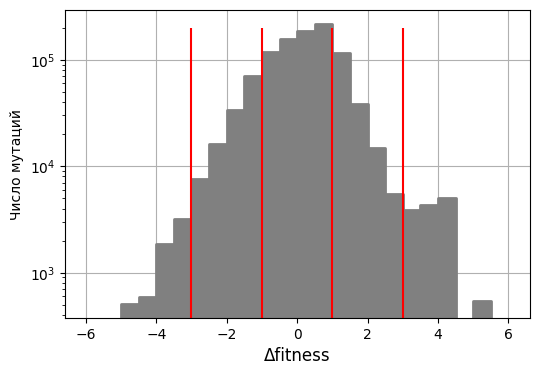

In [62]:
plt.figure(figsize=(6,4))
ax = sns.histplot(
    # aamut_fitness_ns.query('actual_count > 0'), 
    aamut_fitness_ns.query('clade == @clade & not subset_of_ORF1ab'), 
    weights='actual_count', 
    x='delta_fitness', 
    # hue='clade', hue_order=clades_mut_cnt[clades_mut_cnt>100000].index,
    # stat="density", common_norm=False,
    element="step", 
    binwidth=0.5, binrange=(-6, 6), alpha=1, color='gray', linewidth=2, 
)
ax.grid()
# ax.set_title(clade)
ax.vlines([-3, -1, 1, 3], 0, ax.get_yticks()[-2], 'red', linewidth=1.5)
ax.set_ylabel('Число мутаций')
ax.set_xlabel('Δfitness', fontsize=12)
ax.set_axisbelow(True)
ax.set_yscale('log')

In [32]:
clades_mut_cnt[clades_mut_cnt>90000]

clade
22C      98021
20A     103442
24A     105676
21I     132706
23A     149559
22E     150185
20I     335836
21L     502165
22B     543905
21K     627867
21J    1603754
Name: actual_count, dtype: int64

In [6]:
downsample = False
clades_mut_cnt = aamut_fitness_ns.groupby('clade')['actual_count'].sum().sort_values()
clades_df_df_res = []
for clade in clades_mut_cnt[clades_mut_cnt>90000].index:
    print('Processing clade:', clade)
    spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

    spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
    df_changes = collect_possible_changes(1, spectrum_dct)
    exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
        .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

    aamut_fitness_ns_clade = aamut_fitness_ns.query(
        'clade == @clade & not subset_of_ORF1ab & actual_count > 0')\
        .rename(columns={'actual_count': 'count'})
    aas = prepare_aa_subst(aamut_fitness_ns_clade, exp_aa_subst_cur, aa_freqs_total_dct)
    cur_met = calc_metrics(aas)
    corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
    mut_type_cnt = aas.nobs.ne(0).sum()
    mut_cnt = aas.nobs.sum()

    _data = []
    _data.append(['total', cur_met['r2'], corrr, mut_cnt, mut_type_cnt])

    # aa_muts_for_down = aamut_fitness_ns_clade[['aa1', 'aa2']]\
    # aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness > 3')[['aa1', 'aa2']]\
    aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness < -3')[['aa1', 'aa2']]\
        .drop_duplicates().reset_index(drop=True)

    for (b1, b2), label in zip(
        [[-np.inf, -3], [-3, -1], [-1, 1], [1, 3], [3, np.inf]],
        ['deleterious (df< -3)', 'slightly deleterious (-3<df< -1)', 'neutral (-1<df< 1)', 'slightly beneficial (1<df<3)', 'beneficial (df> 3)']
        ):
        cur_mut = aamut_fitness_ns_clade[aamut_fitness_ns_clade.delta_fitness.between(b1, b2, 'right')]

        if downsample:
            print('INFO: downsampling mutations for', label)
            cur_mut_down = cur_mut.merge(aa_muts_for_down)
            nmut = cur_mut['count'].sum()
            print(nmut, len(cur_mut_down))
            if nmut <= 500:
                print(f'WARNING: less than 500 {label} mutations ({nmut}) --> don\'t assess the model')
                _data.append([label, np.nan, np.nan, np.nan, np.nan])
                continue
            # elif nmut > 6110:
            elif len(cur_mut_down) > 10:
                cur_mut = cur_mut_down
            else:
                print(f'INFO: low number of {label} mutations')

        aas = prepare_aa_subst(cur_mut, exp_aa_subst_cur, aa_freqs_total_dct)
        if len(cur_mut) == 0:
            print(f'WARNING: no {label} mutations in clade {clade} --> skip')
            _data.append([label, np.nan, np.nan, np.nan, np.nan])
            continue
        cur_met = calc_metrics(aas)
        corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
        mut_type_cnt = aas.nobs.ne(0).sum()
        mut_cnt = aas.nobs.sum()
        _data.append([label, cur_met['r2'], corrr, mut_cnt, mut_type_cnt])

    df_df_res = pd.DataFrame(
        _data, columns=['mut_sample', 'r2', 'spearman_corr', 'mut_cnt', 'mut_type_cnt']
    )

    df_df_res_for_plot = df_df_res.copy()
    # df_df_res_for_plot['mut_sample'] = df_df_res_for_plot['mut_sample'].str.replace(' ', '\n')
    clades_df_df_res.append(df_df_res_for_plot.assign(clade=clade))

clades_df_df_res = pd.concat(clades_df_df_res, ignore_index=True)
clades_df_df_res['time_period'] = clades_df_df_res['clade'].map(_clade2label)
clades_df_df_res.head()

Processing clade: 22C
Processing clade: 20A
Processing clade: 24A
Processing clade: 21I
Processing clade: 23A
Processing clade: 22E
Processing clade: 20I
Processing clade: 21L
Processing clade: 22B
Processing clade: 21K
Processing clade: 21J


,mut_sample,r2,spearman_corr,mut_cnt,mut_type_cnt,clade,time_period
0,total,0.688344,0.798842,60226.0,150.0,22C,Late clades\n(Omicron+)
1,deleterious (df< -3),NaN,NaN,NaN,NaN,22C,Late clades\n(Omicron+)
2,slightly deleterious (-3<df< -1),0.726806,0.776567,4056.0,44.0,22C,Late clades\n(Omicron+)
3,neutral (-1<df< 1),0.692046,0.832022,42527.0,150.0,22C,Late clades\n(Omicron+)
4,slightly beneficial (1<df<3),0.405570,0.506090,12890.0,138.0,22C,Late clades\n(Omicron+)


/tmp/ipykernel_145970/2228869335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _['time_period'] = _['time_period'].map({'Early clades':'Ранние', 'Late clades\n(Omicron+)': 'Поздние\n(Омикрон+)'})
/tmp/ipykernel_145970/2228869335.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(_labes, fontsize=16)


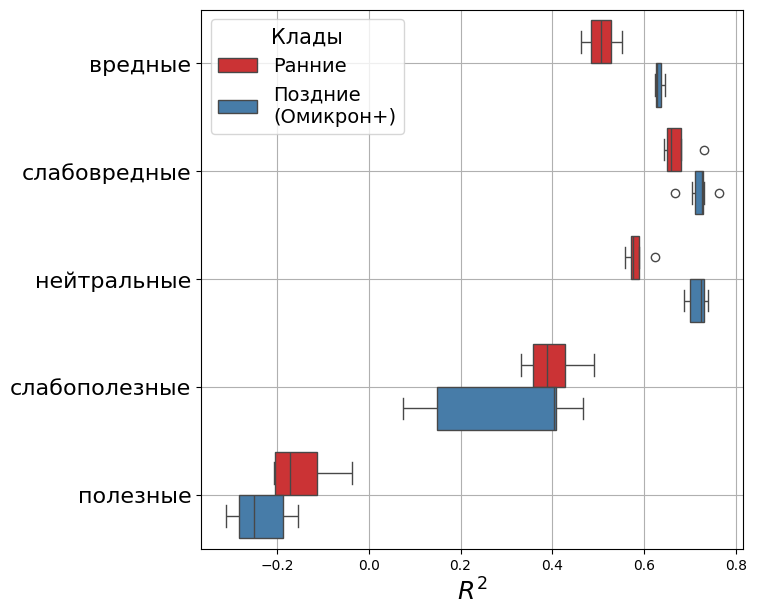

In [13]:
plt.figure(figsize=(7, 7))

_ = clades_df_df_res.query('mut_sample != "total"')
_['time_period'] = _['time_period'].map({'Early clades':'Ранние', 'Late clades\n(Omicron+)': 'Поздние\n(Омикрон+)'})
ax = sns.boxplot(_, y='mut_sample', x='r2', hue='time_period', palette='Set1',
                 hue_order=['Ранние', 'Поздние\n(Омикрон+)']
)
ax.set_ylabel('')
_labes = 'вредные, слабовредные, нейтральные, слабополезные, полезные'.split(', ')
ax.set_yticklabels(_labes, fontsize=16)
ax.set_xlabel('$R^2$', fontsize=18)
plt.grid()
plt.legend(title='Клады', fontsize=14, title_fontsize=15, loc='upper left')

In [43]:
print(pg.pairwise_tests(clades_df_df_res.query('mut_sample == "deleterious (df< -3)"'), dv='r2', between='time_period', parametric=False)['p-unc'].item())
print(pg.pairwise_tests(clades_df_df_res.query('mut_sample == "slightly deleterious (-3<df< -1)"'), dv='r2', between='time_period', parametric=False)['p-unc'].item())
print(pg.pairwise_tests(clades_df_df_res.query('mut_sample == "neutral (-1<df< 1)"'), dv='r2', between='time_period', parametric=False)['p-unc'].item())
print(pg.pairwise_tests(clades_df_df_res.query('mut_sample == "slightly beneficial (1<df<3)"'), dv='r2', between='time_period', parametric=False)['p-unc'].item())
print(pg.pairwise_tests(clades_df_df_res.query('mut_sample == "beneficial (df> 3)"'), dv='r2', between='time_period', parametric=False)['p-unc'].item())

0.2
0.10909090909090909
0.006060606060606061
0.5272727272727272
0.16363636363636364


In [66]:
print('R2')
clades_df_df_res.pivot(index=['clade'], columns='mut_sample', values='r2').round(2).iloc[:, [1, 4, 2, 3, 0, 5]]

R2


mut_sample,deleterious (df< -3),slightly deleterious (-3<df< -1),neutral (-1<df< 1),slightly beneficial (1<df<3),beneficial (df> 3),total
clade,,,,,,
20A,NaN,0.64,0.58,0.33,-0.21,0.58
20I,0.46,0.73,0.62,0.49,-0.14,0.65
21I,NaN,0.65,0.56,0.41,-0.04,0.58
21J,0.55,0.66,0.58,0.37,-0.20,0.59
21K,0.63,0.72,0.74,0.40,-0.27,0.73
21L,0.62,0.76,0.71,0.47,-0.30,0.70
22B,0.64,0.72,0.69,0.41,-0.31,0.68
22E,NaN,0.73,0.73,0.13,-0.25,0.70
23A,NaN,0.67,0.72,0.08,-0.15,0.68


In [67]:
print('mut_type_cnt')
clades_df_df_res.pivot(index=['clade'], columns='mut_sample', values='mut_type_cnt').round(2).iloc[:, [1, 4, 2, 3, 0, 5]]

mut_type_cnt


mut_sample,deleterious (df< -3),slightly deleterious (-3<df< -1),neutral (-1<df< 1),slightly beneficial (1<df<3),beneficial (df> 3),total
clade,,,,,,
20A,NaN,31.0,149.0,136.0,19.0,149.0
20I,29.0,74.0,150.0,135.0,23.0,150.0
21I,NaN,44.0,149.0,139.0,10.0,149.0
21J,45.0,137.0,150.0,134.0,22.0,150.0
21K,30.0,90.0,150.0,138.0,28.0,150.0
21L,30.0,100.0,150.0,138.0,30.0,150.0
22B,30.0,90.0,150.0,134.0,31.0,150.0
22E,NaN,46.0,150.0,139.0,21.0,150.0
23A,NaN,46.0,150.0,137.0,17.0,150.0


In [69]:
print('mut_cnt')
clades_df_df_res.pivot(index=['clade'], columns='mut_sample', values='mut_cnt').round(2).iloc[:, [1, 4, 2, 3, 0, 5]]

mut_cnt


mut_sample,deleterious (df< -3),slightly deleterious (-3<df< -1),neutral (-1<df< 1),slightly beneficial (1<df<3),beneficial (df> 3),total
clade,,,,,,
20A,NaN,4695.0,44193.0,14654.0,1023.0,64565.0
20I,935.0,20783.0,137396.0,46709.0,5171.0,210994.0
21I,NaN,6595.0,58216.0,16416.0,1494.0,82721.0
21J,6109.0,127374.0,676682.0,175143.0,15893.0,1001201.0
21K,1385.0,39853.0,265502.0,68751.0,8040.0,383531.0
21L,1394.0,31934.0,205171.0,60104.0,10297.0,308900.0
22B,1234.0,37855.0,225541.0,65175.0,8978.0,338783.0
22E,NaN,7441.0,67948.0,16441.0,1869.0,93699.0
23A,NaN,6702.0,68590.0,16909.0,1955.0,94156.0


6109 2102
127374 5276
676682 5068
175143 257
15893 2
INFO: low number of beneficial mutations


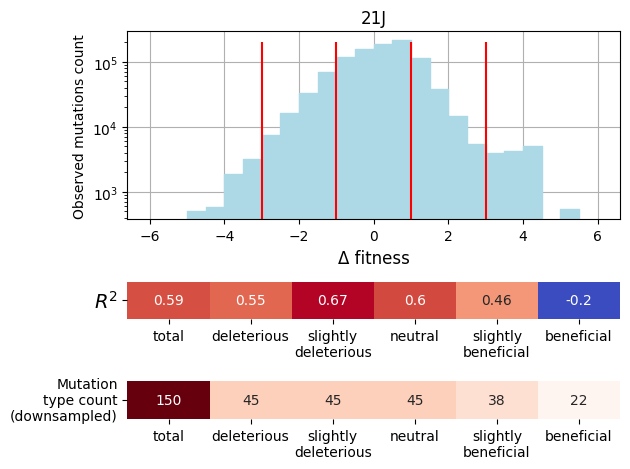

In [ ]:
# clade = '24A'
clade = '21J'

spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
df_changes = collect_possible_changes(1, spectrum_dct)
exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
    .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

aamut_fitness_ns_clade = aamut_fitness_ns.query(
    'clade == @clade & not subset_of_ORF1ab & actual_count > 0')\
    .rename(columns={'actual_count': 'count'})
aas = prepare_aa_subst(aamut_fitness_ns_clade, exp_aa_subst_cur, aa_freqs_total_dct)
cur_met = calc_metrics(aas)
corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
mut_type_cnt = aas.nobs.ne(0).sum()
mut_cnt = aas.nobs.sum()

_data = []
_data.append(['total', cur_met['r2'], corrr, mut_cnt, mut_type_cnt])

# aa_muts_for_down = aamut_fitness_ns_clade[['aa1', 'aa2']]\
# aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness > 3')[['aa1', 'aa2']]\
aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness < -3')[['aa1', 'aa2']]\
    .drop_duplicates().reset_index(drop=True)

for (b1, b2), label in zip(
    [[-np.inf, -3], [-3, -1], [-1, 1], [1, 3], [3, np.inf]],
    ['deleterious', 'slightly deleterious', 'neutral', 'slightly beneficial', 'beneficial']
    ):
    cur_mut = aamut_fitness_ns_clade[aamut_fitness_ns_clade.delta_fitness.between(b1, b2, 'right')]
    cur_mut_down = cur_mut.merge(aa_muts_for_down)
    nmut = cur_mut['count'].sum()
    print(nmut, len(cur_mut_down))clades_mut_cnt[clades_mut_cnt>100000]
    if nmut <= 500:
        print(f'WARNING: less than 500 {label} mutations ({nmut}) --> don\'t assess the model')
        _data.append([label, np.nan, np.nan, np.nan, np.nan])
        continue
    # elif nmut > 6110:
    elif len(cur_mut_down) > 10:
        cur_mut = cur_mut_down
    else:
        print(f'INFO: low number of {label} mutations')

    aas = prepare_aa_subst(cur_mut, exp_aa_subst_cur, aa_freqs_total_dct)
    cur_met = calc_metrics(aas)
    corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
    mut_type_cnt = aas.nobs.ne(0).sum()
    mut_cnt = aas.nobs.sum()
    _data.append([label, cur_met['r2'], corrr, mut_cnt, mut_type_cnt])

df_df_res = pd.DataFrame(
    _data, columns=['mut_sample', 'r2', 'spearman_corr', 'mut_cnt', 'mut_type_cnt']
)#.assign(clade=clade)

df_df_res_for_plot = df_df_res.copy()
df_df_res_for_plot['mut_sample'] = df_df_res_for_plot['mut_sample'].str.replace(' ', '\n')

fig, axs = plt.subplots(3, 1, height_ratios=[5, 1, 1])

ax = sns.histplot(
    # aamut_fitness_ns.query('actual_count > 0'), 
    aamut_fitness_ns.query('clade == @clade & not subset_of_ORF1ab'), 
    weights='actual_count', 
    x='delta_fitness', 
    # hue='clade', hue_order=clades_mut_cnt[clades_mut_cnt>100000].index,
    # stat="density", common_norm=False,
    element="step", 
    binwidth=0.5, binrange=(-6, 6), alpha=1, color='lightblue', ax=axs[0]
)
axs[0].grid()
axs[0].set_title(clade)
axs[0].vlines([-3, -1, 1, 3], 0, axs[0].get_yticks()[-2], 'red', linewidth=1.5)
axs[0].set_ylabel('Observed mutations count')
axs[0].set_xlabel('Δ fitness', fontsize=12)
axs[0].set_axisbelow(True)
axs[0].set_yscale('log')

sns.heatmap(df_df_res_for_plot.set_index('mut_sample')[['r2']].T, ax=axs[1],
            cmap='coolwarm', annot=True, cbar=False)
axs[1].set_xlabel('')
axs[1].set_yticklabels(['$R^2$'], rotation=0, fontsize=14)

sns.heatmap(df_df_res_for_plot.set_index('mut_sample')[['mut_type_cnt']].T, ax=axs[2],
            cmap='Reds', annot=True, cbar=False, fmt='.0f', )
axs[2].set_xlabel('')
axs[2].set_yticklabels(['Mutation\ntype count\n(downsampled)'], rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig(f'./figures/delta_fitness_res_{clade}.pdf')
plt.show()

In [67]:
df_df_res

,mut_sample,r2,spearman_corr,mut_cnt,mut_type_cnt
0,deleterious,0.012113,NaN,275.0,2
1,slightly deleterious,-0.052415,NaN,8302.0,18
2,neutral,-0.157055,-0.212144,47484.0,22
3,slightly beneficial,-0.160330,-0.237774,19719.0,21
4,beneficial,-0.202266,-0.224421,15893.0,22


In [70]:
df_df_res

,mut_sample,r2,spearman_corr,mut_cnt,mut_type_cnt
0,deleterious,0.550609,0.790395,6109.0,45
1,slightly deleterious,0.673507,0.790416,103658.0,45
2,neutral,0.598961,0.790873,517594.0,45
3,slightly beneficial,0.460510,0.724139,120325.0,38
4,beneficial,-0.202266,-0.224421,15893.0,22


In [72]:
df_df_res

,mut_sample,r2,spearman_corr,mut_cnt,mut_type_cnt
0,deleterious,0.550609,0.790395,6109.0,45
1,slightly deleterious,0.664014,0.884018,127374.0,137
2,neutral,0.575700,0.813693,676682.0,150
3,slightly beneficial,0.367789,0.476235,175143.0,134
4,beneficial,-0.202266,-0.224421,15893.0,22


### Check that 22 muttypes are non-randomly decrease R2

In [107]:
clade = '21J'

clades_mut_cnt = aamut_fitness_ns.groupby('clade')['actual_count'].sum().sort_values()

spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
df_changes = collect_possible_changes(1, spectrum_dct)
exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
    .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

aamut_fitness_ns_clade = aamut_fitness_ns.query(
    'clade == @clade & not subset_of_ORF1ab & actual_count > 0')\
    .rename(columns={'actual_count': 'count'})

_data = []
aa_muts_total = aamut_fitness_ns_clade[['aa1', 'aa2']].drop_duplicates().reset_index(drop=True)
aa_muts_for_down = aamut_fitness_ns_clade.query('delta_fitness > 3')[['aa1', 'aa2']]\
    .drop_duplicates().reset_index(drop=True)

for (b1, b2), label in zip(
    [[-np.inf, -3], [-3, -1], [-1, 1], [1, 3], [3, np.inf]],
    ['deleterious (df< -3)', 'slightly deleterious (-3<df< -1)', 'neutral (-1<df< 1)', 'slightly beneficial (1<df<3)', 'beneficial (df> 3)']
    ):
    for replic in range(0, 100):
        # print(f'Processing {label} mutations for clade {clade}, replication {replic}')
        cur_mut = aamut_fitness_ns_clade[aamut_fitness_ns_clade.delta_fitness.between(b1, b2, 'right')]
        
        if replic == 0:
            cur_mut_down = cur_mut.merge(aa_muts_for_down)
        else:
            if label == 'beneficial (df> 3)':
                continue
            aa_muts_for_replic = aa_muts_total.sample(len(aa_muts_for_down), replace=False, random_state=replic)
            cur_mut_down = cur_mut.merge(aa_muts_for_replic)
        # print('INFO: downsampling mutations for', label)
        nmut = cur_mut['count'].sum()
        # print(nmut, len(cur_mut_down))
        if nmut <= 500:
            print(f'WARNING: less than 500 {label} mutations ({nmut}) --> don\'t assess the model')
            _data.append([label, np.nan, np.nan, np.nan, np.nan])
            continue
        elif len(cur_mut_down) >= 10:
            cur_mut = cur_mut_down
        else:
            print(f'INFO: low number of {label} mutation types (<10)')

        aas = prepare_aa_subst(cur_mut, exp_aa_subst_cur, aa_freqs_total_dct)
        if len(cur_mut) == 0:
            print(f'WARNING: no {label} mutations in clade {clade} --> skip')
            _data.append([label, np.nan, np.nan, np.nan, np.nan])
            continue
        cur_met = calc_metrics(aas)
        corrr = cur_met['spearman_corr'] if cur_met['spearman_p'] < 0.01 else np.nan
        mut_type_cnt = aas.nobs.ne(0).sum()
        mut_cnt = aas.nobs.sum()
        _data.append([label, cur_met['r2'], corrr, mut_cnt, mut_type_cnt, replic])

df_df_res = pd.DataFrame(
    _data, columns=['mut_sample', 'r2', 'spearman_corr', 'mut_cnt', 'mut_type_cnt', 'replicate']
)#.assign(clade=clade)

In [108]:
df_df_res.query('replicate == 0')

,mut_sample,r2,spearman_corr,mut_cnt,mut_type_cnt,replicate
0,deleterious (df< -3),0.012115,NaN,275.0,2,0
100,slightly deleterious (-3<df< -1),-0.052504,NaN,8302.0,18,0
200,neutral (-1<df< 1),-0.157237,-0.212144,47484.0,22,0
300,slightly beneficial (1<df<3),-0.160448,-0.237898,19719.0,21,0
400,beneficial (df> 3),-0.202282,-0.224421,15893.0,22,0


In [114]:
df_df_res.query('replicate > 0').groupby('mut_sample').r2.quantile(0.05)

mut_sample
deleterious (df< -3)               -0.013418
neutral (-1<df< 1)                 -0.144580
slightly beneficial (1<df<3)       -0.128394
slightly deleterious (-3<df< -1)   -0.095548
Name: r2, dtype: float64

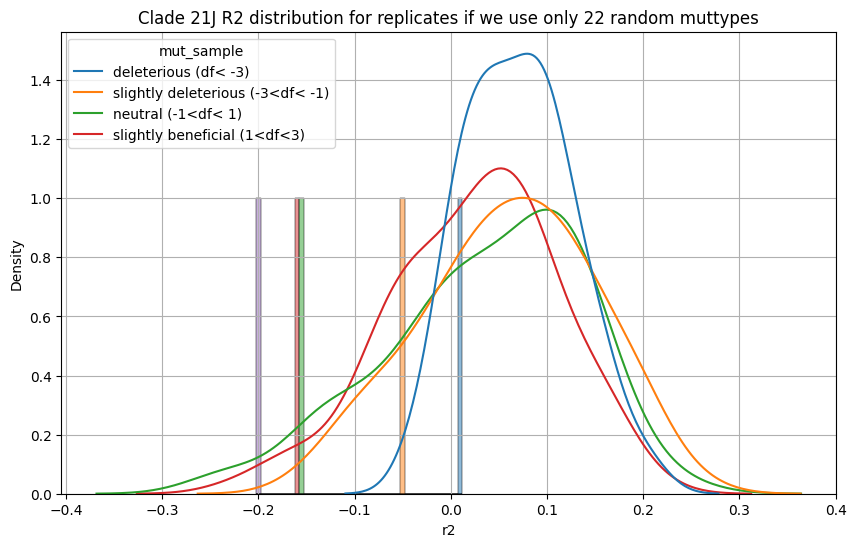

In [115]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_df_res.query('replicate > 0'), x='r2', hue='mut_sample',)
sns.histplot(df_df_res.query('replicate == 0'), 
             x='r2', hue='mut_sample', binwidth=0.005, 
             legend=False, )
plt.grid()
plt.title(f'Clade {clade} R2 distribution for replicates if we use only 22 random muttypes');

In [116]:
aa_muts_for_down

,aa1,aa2
0,T,P
1,D,H
2,F,C
3,F,V
4,G,S
5,K,R
6,P,T
7,V,L
8,M,K
9,Q,P


### try different cutoffs

In [ ]:
clades_mut_cnt = aamut_fitness_ns.groupby('clade')['actual_count'].sum().sort_values()
clades_mut_cnt[clades_mut_cnt>100000]

clade
20A     103442
24A     105676
21I     132706
23A     149559
22E     150185
20I     335836
21L     502165
22B     543905
21K     627867
21J    1603754
Name: actual_count, dtype: int64

In [35]:
data_fitness = []
for clade in clades_mut_cnt[clades_mut_cnt>100000].index:
    print(clade)
    spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

    spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
    df_changes = collect_possible_changes(1, spectrum_dct)
    exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
        .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

    _ = aamut_fitness_ns.query(f'clade == "{clade}" & actual_count > 0')\
        .rename(columns={'actual_count': 'count'})
    aas = prepare_aa_subst(_, exp_aa_subst_cur, aa_freqs_total_dct)
    cur_met = calc_metrics(aas)
    data_fitness.append({
        'clade': clade,
        'fitness_range': 'any df',
        'r2': cur_met['r2'], 
        'spearman_corr': cur_met['spearman_corr'], 
        'mut_count': cur_met['mut_count'], 
        'mut_type_count': aas.nobs.ne(0).sum(), 
    })

    for cutoff in np.linspace(0, 2, 9):
        _ = aamut_fitness_ns.query(f'clade == "{clade}" & actual_count > 0 & delta_fitness < {-cutoff}')\
            .rename(columns={'actual_count': 'count'})
        aas = prepare_aa_subst(_, exp_aa_subst_cur, aa_freqs_total_dct)
        cur_met = calc_metrics(aas)
        data_fitness.append({
            'clade': clade,
            'cutoff': cutoff,
            'fitness_range': f'df<{-cutoff}',
            'r2': cur_met['r2'], 
            'spearman_corr': cur_met['spearman_corr'], 
            'mut_count': cur_met['mut_count'], 
            'mut_type_count': aas.nobs.ne(0).sum(), 
        })
        if cutoff != 0:
            _ = aamut_fitness_ns.query(f'clade == "{clade}" & actual_count > 0 & {-cutoff} < delta_fitness < {cutoff}')\
                .rename(columns={'actual_count': 'count'})
            aas = prepare_aa_subst(_, exp_aa_subst_cur, aa_freqs_total_dct)
            cur_met = calc_metrics(aas)
            data_fitness.append({
                'clade': clade,
                'cutoff': cutoff,
                'fitness_range': f'{-cutoff}<df<{cutoff}',
                'r2': cur_met['r2'], 
                'spearman_corr': cur_met['spearman_corr'], 
                'mut_count': cur_met['mut_count'], 
                'mut_type_count': aas.nobs.ne(0).sum(), 
            })
        _ = aamut_fitness_ns.query(f'clade == "{clade}" & actual_count > 0 & delta_fitness > {cutoff}')\
            .rename(columns={'actual_count': 'count'})
        aas = prepare_aa_subst(_, exp_aa_subst_cur, aa_freqs_total_dct)
        cur_met = calc_metrics(aas)
        data_fitness.append({
            'clade': clade,
            'cutoff': cutoff,
            'fitness_range': f'df>{cutoff}',
            'r2': cur_met['r2'], 
            'spearman_corr': cur_met['spearman_corr'], 
            'mut_count': cur_met['mut_count'], 
            'mut_type_count': aas.nobs.ne(0).sum(), 
        })
data_fitness_df = pd.DataFrame(data_fitness)

20A
24A
21I
23A
22E
20I
21L
22B
21K
21J


In [36]:
data_fitness_df

,clade,fitness_range,r2,spearman_corr,mut_count,mut_type_count,cutoff
0,20A,any df,0.556933,0.808099,103442.0,149,NaN
1,20A,df<-0.0,0.642999,0.881414,33318.0,71,0.00
2,20A,df>0.0,0.475721,0.708343,70124.0,149,0.00
3,20A,df<-0.25,0.663616,0.840041,25966.0,61,0.25
4,20A,-0.25<df<0.25,0.448220,0.831113,18870.0,89,0.25
...,...,...,...,...,...,...,...
265,21J,-1.75<df<1.75,0.551062,0.797757,1456191.0,150,1.75
266,21J,df>1.75,-0.298147,-0.026083,71019.0,76,1.75
267,21J,df<-2.0,0.568597,0.883850,53271.0,90,2.00
268,21J,-2.0<df<2.0,0.548390,0.802644,1497012.0,150,2.00


In [37]:
pd.concat([_, pd.DataFrame([pd.Series(name='AAA'), pd.Series(name='BBB')])], axis=1)

,clade,gene,clade_founder_aa,mutant_aa,aa_site,aa_mutation,expected_count,count,count_terminal,count_non_terminal,mean_log_size,subset_of_ORF1ab,delta_fitness,aa1,aa2
631299,21J,E,V,L,58.0,V58L,7.2389,67.0,38.0,29.0,0.684590,False,2.1659,V,L
631302,21J,E,V,L,75.0,V75L,7.2389,132.0,120.0,12.0,0.069157,False,2.8403,V,L
631542,21J,M,D,H,209.0,D209H,7.2389,67.0,38.0,29.0,0.694520,False,2.1659,D,H
631544,21J,M,D,H,3.0,D3H,7.2389,69.0,40.0,29.0,0.592330,False,2.1951,D,H
631610,21J,M,E,Q,167.0,E167Q,7.2389,90.0,47.0,43.0,0.756860,False,2.4591,E,Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2816369,21J,nsp2,V,E,628.0,V628E,3.6933,58.0,54.0,4.0,0.102950,True,2.6355,V,E
2841807,21J,nsp3,Y,N,1185.0,Y1185N,3.6933,33.0,20.0,13.0,0.781380,True,2.0781,Y,N
2877899,21J,nsp13,Y,H,253.0,Y253H,22.8170,221.0,132.0,89.0,0.685360,True,2.2512,Y,H
AAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
order_df = ['any df', '-0.5<df<0.5', '-0.75<df<0.75', '-1.0<df<1.0',
    '-1.25<df<1.25', '-1.5<df<1.5', 'spliter1',
    'df<-0.0', 'df<-0.5', 'df<-0.75', 'df<-1.0',
    'df<-1.25', 'df<-1.5', 'spliter2', 'df>0.0',
    'df>0.5', 'df>0.75', 'df>1.0', 'df>1.25', 'df>1.5', 
    ]

Text(0.5, 1.0, 'Model quality on mutations with different delta fitness (df)')

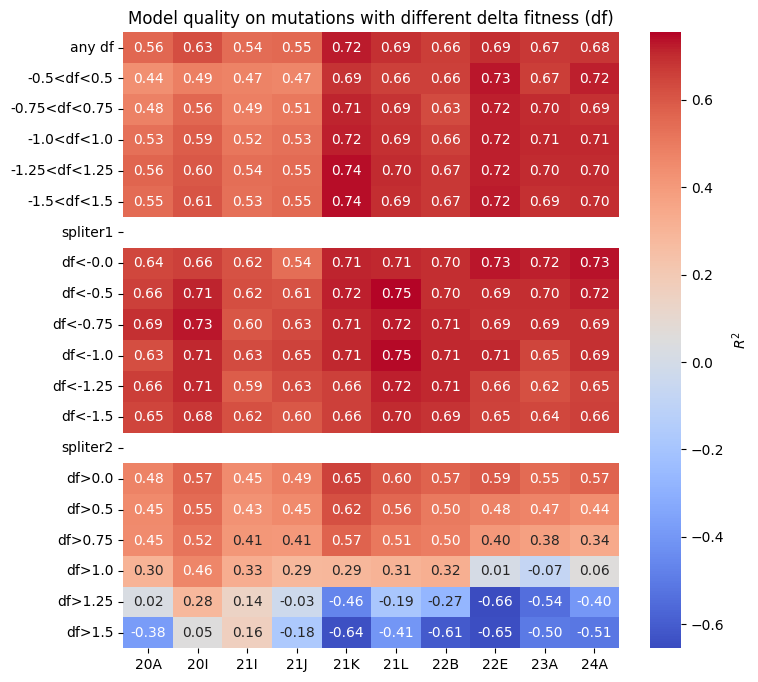

In [39]:
plt.figure(figsize=(8, 8))
_ = data_fitness_df.pivot(columns='clade', index='fitness_range', values='r2')
_ = pd.concat([_, pd.DataFrame([pd.Series(name='spliter1'), pd.Series(name='spliter2')])], axis=1).loc[order_df]
sns.heatmap(_, annot=True, fmt='.2f', 
            # cmap=sns.color_palette("light:g", as_cmap=True), 
            # cmap=sns.light_palette("seagreen", as_cmap=True),
            cmap='coolwarm',
            cbar_kws={'label': '$R^2$'}, )
plt.title('Model quality on mutations with different delta fitness (df)')
# plt.yticks(rotation=0);

Text(0.5, 1.0, 'Mutation type counts for samples with different delta fitness (df)')

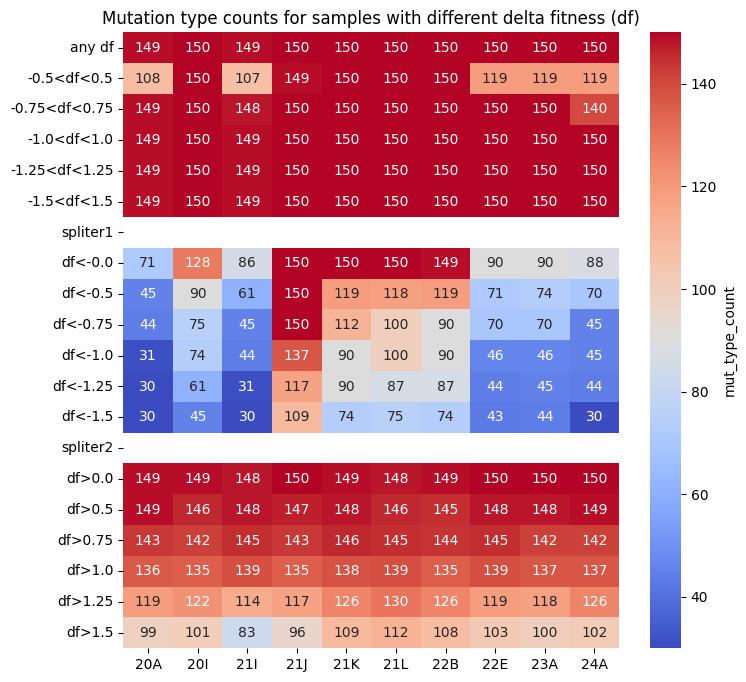

In [45]:
plt.figure(figsize=(8, 8))
_ = data_fitness_df.pivot(columns='clade', index='fitness_range', values='mut_type_count')
_ = pd.concat([_, pd.DataFrame([pd.Series(name='spliter1'), pd.Series(name='spliter2')])], axis=1).loc[order_df]
sns.heatmap(_, annot=True, fmt='.0f', 
            # cmap=sns.color_palette("light:g", as_cmap=True), 
            # cmap=sns.light_palette("seagreen", as_cmap=True),
            cmap='coolwarm',
            cbar_kws={'label': 'mut_type_count'}, )
plt.title('Mutation type counts for samples with different delta fitness (df)')
# plt.yticks(rotation=0);

Text(0.5, 0, 'Clade')

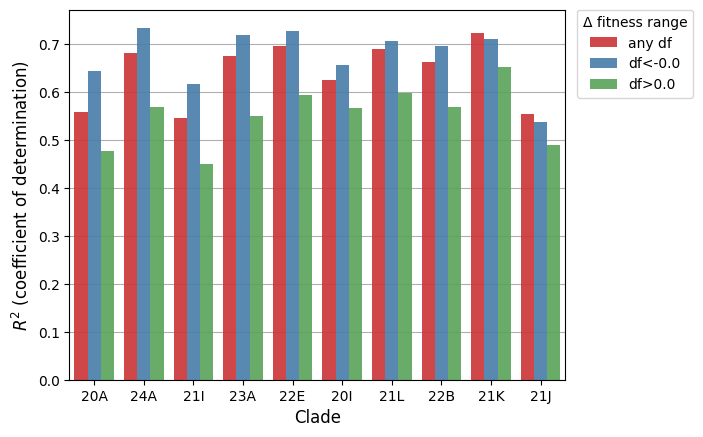

In [80]:
ax = sns.barplot(
    data_fitness_df.fillna(0).query('cutoff == 0'), 
    x='clade', y='r2', hue='fitness_range',
    palette='Set1', alpha=0.9, 
)
plt.legend(title='Δ fitness range', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=12)
plt.xlabel('Clade', fontsize=12)

Text(0.5, 0, 'Clade')

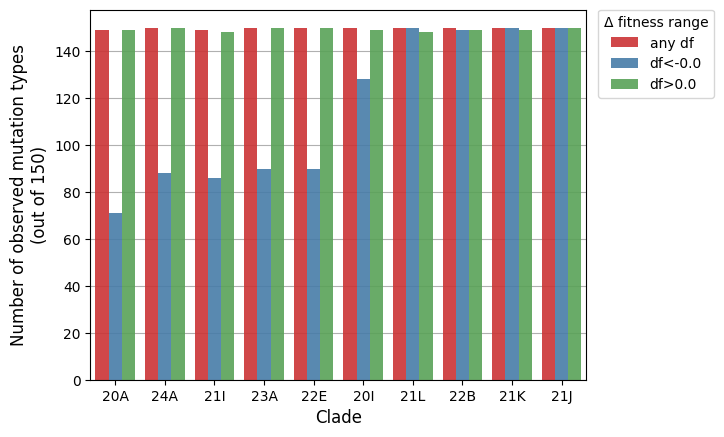

In [82]:
ax = sns.barplot(
    data_fitness_df.fillna(0).query('cutoff == 0'), 
    x='clade', y='mut_type_count', hue='fitness_range',
    palette='Set1', alpha=0.9, 
)
plt.legend(title='Δ fitness range', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.ylabel('Number of observed mutation types\n(out of 150)', fontsize=12)
plt.xlabel('Clade', fontsize=12)

Text(0.5, 0, 'Clade')

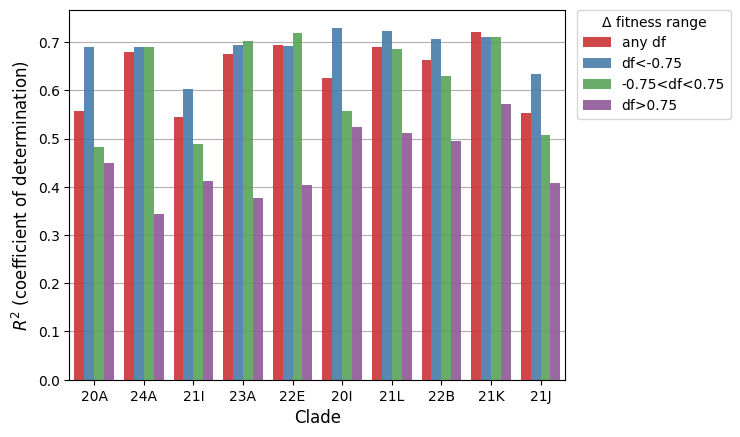

In [76]:
ax = sns.barplot(
    data_fitness_df.fillna(0.75).query('cutoff == 0.75'), 
    x='clade', y='r2', hue='fitness_range',
    palette='Set1', alpha=0.9, 
)
plt.legend(title='Δ fitness range', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=12)
plt.xlabel('Clade', fontsize=12)

Text(0.5, 0, 'Clade')

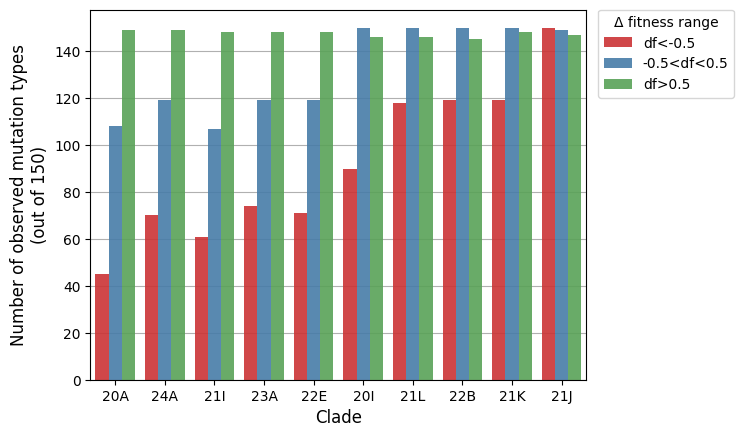

In [78]:
ax = sns.barplot(
    data_fitness_df.query('cutoff == 0.5'), 
    x='clade', y='mut_type_count', hue='fitness_range',
    palette='Set1', alpha=0.9, 
)
plt.legend(title='Δ fitness range', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.ylabel('Number of observed mutation types\n(out of 150)', fontsize=12)
plt.xlabel('Clade', fontsize=12)

Spearman correlation: 0.117 (p-value: 0.152)


/home/kpotoh/env_bio/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_11623/3755427975.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)


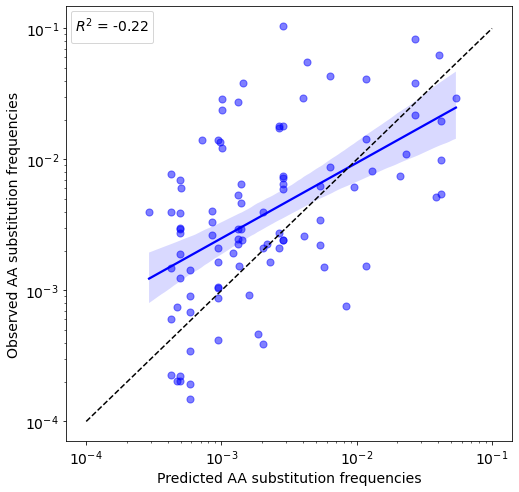

In [346]:
cutoff = 1.5
_ = aamut_fitness_ns.query(f'clade == "21J" & actual_count > 0 & delta_fitness > {cutoff}').rename(columns={'actual_count': 'count'})
aas = prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(aas)

In [354]:
aas['ava'] = aas['nobs_freqs'].mean()
aas['res'] = (aas['nobs_freqs'] - aas['nexp_freqs'])**2
aas['tot'] = (aas['nobs_freqs'] - aas['ava'])**2
1 - aas['res'].sum() / aas['tot'].sum()

np.float64(-0.22444001433241434)

In [352]:
r2_score(aas.nobs_freqs, aas.nexp_freqs), spearmanr(aas.nobs_freqs, aas.nexp_freqs)

(-0.22444001433241434,
 SignificanceResult(statistic=np.float64(0.11744032126622556), pvalue=np.float64(0.15235292239994463)))

<Axes: xlabel='nexp_freqs', ylabel='nobs_freqs'>

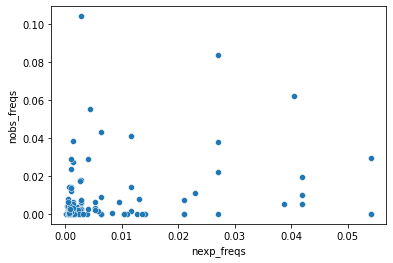

In [347]:
sns.scatterplot(aas, x='nexp_freqs', y='nobs_freqs')

<Axes: xlabel='nexp_freqs', ylabel='nobs_freqs'>

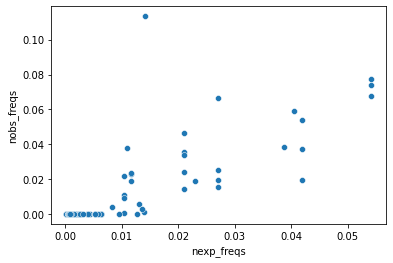

In [317]:
sns.scatterplot(aas, x='nexp_freqs', y='nobs_freqs')

## Fitness of distinct AA

### Prepare site samples of different fitness landscapes

In [44]:
aamut_fitness_ns

,clade,gene,clade_founder_aa,mutant_aa,aa_site,aa_mutation,expected_count,actual_count,count_terminal,count_non_terminal,mean_log_size,subset_of_ORF1ab,delta_fitness,aa1,aa2
4,20A,E,A,D,22,A22D,0.67725,0,0,0,0.0,False,-0.85633,A,D
5,20A,E,A,D,32,A32D,0.67725,0,0,0,0.0,False,-0.85633,A,D
6,20A,E,A,E,36,A36E,0.67725,0,0,0,0.0,False,-0.85633,A,E
7,20A,E,A,E,41,A41E,0.67725,0,0,0,0.0,False,-0.85633,A,E
8,20A,E,A,G,22,A22G,0.23810,0,0,0,0.0,False,-0.38947,A,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2893364,24A,nsp1,Y,D,97,Y97D,0.25363,0,0,0,0.0,True,-0.41029,Y,D
2893365,24A,nsp1,Y,F,97,Y97F,0.77908,0,0,0,0.0,True,-0.93929,Y,F
2893366,24A,nsp1,Y,H,97,Y97H,2.17910,0,0,0,0.0,True,-1.67860,Y,H
2893367,24A,nsp1,Y,N,97,Y97N,0.48805,0,0,0,0.0,True,-0.68113,Y,N


In [21]:
aa_fitness = pd.read_csv('./data/bloom_etal/aa_fitness.csv')
aa_fitness

,gene,aa_site,aa,fitness,expected_count,aa_differs_among_clade_founders,subset_of_ORF1ab
0,E,1,I,-7.1032,607.410,False,False
1,E,1,K,-3.5840,17.508,False,False
2,E,1,L,-4.3124,36.811,False,False
3,E,1,M,0.0000,844.230,False,False
4,E,1,R,-3.1560,11.238,False,False
...,...,...,...,...,...,...,...
122158,nsp9,113,K,-3.4869,48.529,False,True
122159,nsp9,113,L,-2.8511,25.461,False,True
122160,nsp9,113,P,-2.0669,11.350,False,True
122161,nsp9,113,Q,0.0000,925.030,False,True


In [22]:
aa_fitness_ref = aa_fitness.query('fitness == 0').set_index(['gene', 'aa_site'])
aa_fitness_ref

aa  fitness  expected_count  aa_differs_among_clade_founders  \
gene aa_site                                                                
E    1        M      0.0          844.23                            False   
     2        Y      0.0          302.17                            False   
     3        S      0.0          873.08                            False   
     4        F      0.0          287.04                            False   
     5        V      0.0          718.24                            False   
...          ..      ...             ...                              ...   
nsp9 109      T      0.0          888.22                            False   
     110      V      0.0          718.25                            False   
     111      R      0.0         1369.60                            False   
     112      L      0.0          176.26                            False   
     113      Q      0.0          925.03                            False   

              subset_of_ORF1ab  
gene aa_site                    
E    1                   False  
     2                   False  
     3                   False  
     4                   False  
     5                   False  
...                        ...  
nsp9 109                  True  
     110                  True  
     111                  True  
     112                  True  
     113                  True  

[16764 rows x 5 columns]

In [8]:
# ref fitness is 0
aa_fitness_ref.fitness.describe()

count    16764.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: fitness, dtype: float64

In [23]:
site_fitnesses = aa_fitness.pivot(index=['gene', 'aa_site'], columns='aa', values='fitness').fillna(0)
site_fitnesses

aa                  *        A       C      D       E       F       G  \
gene aa_site                                                            
E    1        0.00000  0.00000  0.0000  0.000  0.0000  0.0000  0.0000   
     2       -3.78190  0.00000 -5.1893 -3.156  0.0000 -2.8511  0.0000   
     3       -4.88050 -0.95878  0.0000  0.000  0.0000  0.0000  0.0000   
     4        0.00000  0.00000 -3.1560  0.000  0.0000  0.0000  0.0000   
     5        0.00000 -2.27390  0.0000 -3.584  0.0000 -2.2231 -2.0574   
...               ...      ...     ...    ...     ...     ...     ...   
nsp9 109      0.00000 -5.18930  0.0000  0.000  0.0000  0.0000  0.0000   
     110      0.00000 -5.10710  0.0000  0.000 -2.4854  0.0000 -2.0574   
     111      0.00000  0.00000 -7.2405  0.000  0.0000  0.0000 -3.5451   
     112     -0.79691  0.00000  0.0000  0.000  0.0000 -1.0741  0.0000   
     113     -5.63110  0.00000  0.0000  0.000 -2.4465  0.0000  0.0000   

aa                  H        I       K  ...    M      N       P       Q  \
gene aa_site                            ...                               
E    1        0.00000 -7.10320 -3.5840  ...  0.0  0.000  0.0000  0.0000   
     2       -2.27390  0.00000  0.0000  ...  0.0 -3.584  0.0000  0.0000   
     3        0.00000  0.00000  0.0000  ...  0.0  0.000 -0.7633  0.0000   
     4        0.00000 -2.48540  0.0000  ...  0.0  0.000  0.0000  0.0000   
     5        0.00000  0.72401  0.0000  ...  0.0  0.000  0.0000  0.0000   
...               ...      ...     ...  ...  ...    ...     ...     ...   
nsp9 109      0.00000  1.11350 -2.0206  ...  0.0  0.000 -3.1655  0.0000   
     110      0.00000 -1.46820  0.0000  ...  0.0  0.000  0.0000  0.0000   
     111     -4.85820  0.00000  0.0000  ...  0.0  0.000 -1.8907  0.0000   
     112      0.00000 -0.80668  0.0000  ...  0.0  0.000 -5.0843 -3.5662   
     113     -0.81593  0.00000 -3.4869  ...  0.0  0.000 -2.0669  0.0000   

aa                 R       S       T       V    W       Y  
gene aa_site                                               
E    1       -3.1560  0.0000 -5.1071 -4.0907  0.0  0.0000  
     2        0.0000 -3.1655  0.0000  0.0000  0.0  0.0000  
     3        0.0000  0.0000 -1.1861  0.0000  0.0  0.0000  
     4        0.0000 -3.1612  0.0000 -3.1560  0.0 -1.9745  
     5        0.0000  0.0000  0.0000  0.0000  0.0  0.0000  
...              ...     ...     ...     ...  ...     ...  
nsp9 109     -3.5451 -3.9498  0.0000  0.0000  0.0  0.0000  
     110      0.0000  0.0000  0.0000  0.0000  0.0  0.0000  
     111      0.0000 -4.5855  0.0000  0.0000  0.0  0.0000  
     112     -3.1308 -1.5527  0.0000 -2.4446  0.0  0.0000  
     113     -5.1893  0.0000  0.0000  0.0000  0.0  0.0000  

[16764 rows x 21 columns]

In [25]:
X_descr = aa_fitness.query('aa != "*" & fitness != 0')\
    .groupby(['gene', 'aa_site'])['fitness'].aggregate(['min', 'max', 'mean', 'median', 'std', 'count']).join(
        aa_fitness.query('aa != "*"').groupby(['gene', 'aa_site'])\
            ['fitness'].max().rename('max=0') == 0)
X_descr = X_descr.join(aa_fitness_ref[['aa', 'subset_of_ORF1ab']]).rename(columns={'aa': 'ref_aa'})
X_descr

min      max      mean   median       std  count  max=0  \
gene aa_site                                                               
E    1       -7.1032 -3.15600 -4.558900 -4.20155  1.412269      6   True   
     2       -5.1893 -2.27390 -3.369967 -3.16075  0.991358      6   True   
     3       -2.4956 -0.76330 -1.350945 -1.07244  0.782417      4   True   
     4       -3.1612 -0.36699 -2.383348 -2.82070  1.099300      6   True   
     5       -3.5840  0.72401 -1.498047 -2.14025  1.698920      6  False   
...              ...      ...       ...      ...       ...    ...    ...   
nsp9 109     -5.1893  1.11350 -2.792800 -3.35530  2.174497      6  False   
     110     -5.1071 -1.46820 -2.825300 -2.48540  1.395265      5   True   
     111     -7.2405 -1.89070 -4.397983 -4.42670  1.752579      6   True   
     112     -5.0843 -0.80668 -2.522769 -2.44460  1.528106      7   True   
     113     -5.1893 -0.81593 -2.809438 -2.64880  1.468441      6   True   

             ref_aa  subset_of_ORF1ab  
gene aa_site                           
E    1            M             False  
     2            Y             False  
     3            S             False  
     4            F             False  
     5            V             False  
...             ...               ...  
nsp9 109          T              True  
     110          V              True  
     111          R              True  
     112          L              True  
     113          Q              True  

[16764 rows x 9 columns]

In [26]:
X_descr['count'].value_counts()

count
6     10663
7      2731
5      2171
4       964
9       126
10       44
8        32
11       14
3         8
13        5
12        5
14        1
Name: count, dtype: int64

In [27]:
# Sharp peaks
# X_descr.query('mean < -3')
# sites_plateau = X_descr.query('-1 < mean < 1 & std < 1.5')

## initial classification with some assumtions
# X_descr['landscape_char'] = 'none'
# X_descr.loc[(X_descr['mean'] < -3), 'landscape_char'] = 'rock'
# X_descr.loc[(X_descr['mean'].between(-3, -1))&(X_descr['max=0']), 'landscape_char'] = 'hill'
# X_descr.loc[(X_descr['mean'].between(-3, -1))&(~X_descr['max=0']), 'landscape_char'] = 'climb'
# X_descr.loc[(X_descr['mean'].between(-1, 2 ))&(X_descr['std'] < 1), 'landscape_char'] = 'plateau'
# X_descr.loc[(X_descr['mean'].between(-1, 2 ))&(X_descr['std'] > 1), 'landscape_char'] = 'canyon'


X_descr.loc[(X_descr['max=0']), 'landscape_char'] = 'ref_is_highest'
X_descr.loc[(~X_descr['max=0']), 'landscape_char'] = 'ref_is_not_highest'


In [28]:
X_descr.landscape_char.value_counts()

landscape_char
ref_is_highest        9946
ref_is_not_highest    6818
Name: count, dtype: int64

Text(0.5, 0, 'mean (mount height)')

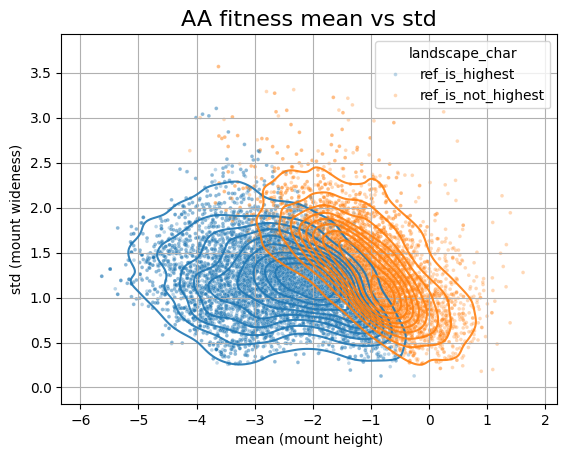

In [56]:
ax=sns.kdeplot(X_descr.sample(frac=0.5), x='mean', y='std', hue='landscape_char', alpha=0.9)
sns.scatterplot(X_descr, x='mean', y='std', hue='landscape_char', alpha=0.3, s=7, ax=ax)
plt.title('AA fitness mean vs std', fontsize=16)
# plt.plot([-3, 0], [0, 3])
# plt.vlines([-1, 2], 0, 1.5, color='purple', linestyle='--', label='plateau')
# plt.hlines([0, 1.5], -1, 2, color='purple', linestyle='--', label='plateau')
# plt.vlines([-3], 0, 3, color='red', linestyle='--', label='peak')
plt.grid()
plt.ylabel('std (mount wideness)')
plt.xlabel('mean (mount height)')

In [29]:
X_descr.to_csv('./data/sites_landscape_labels.csv')

### Assess model on different landscapes

In [33]:
X_descr = pd.read_csv('./data/sites_landscape_labels.csv', index_col=[0,1])
X_descr.head()

min      max      mean   median       std  count  max=0  \
gene aa_site                                                               
E    1       -7.1032 -3.15600 -4.558900 -4.20155  1.412269      6   True   
     2       -5.1893 -2.27390 -3.369967 -3.16075  0.991358      6   True   
     3       -2.4956 -0.76330 -1.350945 -1.07244  0.782417      4   True   
     4       -3.1612 -0.36699 -2.383348 -2.82070  1.099300      6   True   
     5       -3.5840  0.72401 -1.498047 -2.14025  1.698920      6  False   

             ref_aa  subset_of_ORF1ab      landscape_char  
gene aa_site                                               
E    1            M             False      ref_is_highest  
     2            Y             False      ref_is_highest  
     3            S             False      ref_is_highest  
     4            F             False      ref_is_highest  
     5            V             False  ref_is_not_highest

In [37]:
aamut_fitness_ns_lbl = aamut_fitness_ns.merge(X_descr[['landscape_char']].reset_index())
aamut_fitness_ns_lbl.head()

,clade,gene,clade_founder_aa,mutant_aa,aa_site,aa_mutation,expected_count,actual_count,count_terminal,count_non_terminal,mean_log_size,subset_of_ORF1ab,delta_fitness,aa1,aa2,landscape_char
0,20A,E,A,D,22,A22D,0.67725,0,0,0,0.0,False,-0.85633,A,D,ref_is_highest
1,20A,E,A,D,32,A32D,0.67725,0,0,0,0.0,False,-0.85633,A,D,ref_is_highest
2,20A,E,A,E,36,A36E,0.67725,0,0,0,0.0,False,-0.85633,A,E,ref_is_highest
3,20A,E,A,E,41,A41E,0.67725,0,0,0,0.0,False,-0.85633,A,E,ref_is_highest
4,20A,E,A,G,22,A22G,0.23810,0,0,0,0.0,False,-0.38947,A,G,ref_is_highest


In [39]:
aamut_fitness_ns_lbl.groupby(['landscape_char', 'subset_of_ORF1ab']).actual_count.sum().unstack()

subset_of_ORF1ab,False,True
landscape_char,,
ref_is_highest,707126,550786
ref_is_not_highest,2439655,1361497


In [68]:
aamut_fitness_ns_lbl.groupby('subset_of_ORF1ab').gene.unique()

subset_of_ORF1ab
False    [E, M, N, ORF10, ORF1ab, ORF3a, ORF6, ORF7a, O...
True     [nsp3, nsp1, nsp2, nsp4, nsp5 (Mpro), nsp6, ns...
Name: gene, dtype: object

In [40]:
clades_mut_cnt = aamut_fitness_ns.groupby('clade')['actual_count'].sum()#.sort_values()
clades_mut_cnt[clades_mut_cnt>100000]

clade
20A     103442
20I     335836
21I     132706
21J    1603754
21K     627867
21L     502165
22B     543905
22E     150185
23A     149559
24A     105676
Name: actual_count, dtype: int64

In [ ]:
data_fitness_sites = []
d_to_eq_data = []
for clade in clades_mut_cnt.index:
    print(clade, end=' ')
    spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

    exp_aa_subst_cur = prepare_exp_aa_subst(spectrum_cur)[0]
    
    n_to_sample = aamut_fitness_ns_lbl.query(f'clade == "{clade}"').groupby('landscape_char')\
        ['actual_count'].sum().sort_values().iloc[0]

    for (lchar, genome_part), cur_aamut in aamut_fitness_ns_lbl\
        .groupby(['landscape_char', 'subset_of_ORF1ab']):

        cur_aa_freqs_dct = X_descr\
            .query(f'landscape_char == "{lchar}" & subset_of_ORF1ab == {genome_part}')\
                .ref_aa.value_counts().rename(index=amino_acid_codes).to_dict()

        cur_aamut_flt = cur_aamut\
            .query(f'clade == "{clade}" & actual_count > 0')\
                .rename(columns={'actual_count': 'count'})


        aas = prepare_aa_subst(cur_aamut_flt, exp_aa_subst_cur, cur_aa_freqs_dct)
        cur_met = calc_metrics(aas)
        data_fitness_sites.append({
            'clade': clade,
            'landscape_char': lchar,
            'subset_of_ORF1ab': genome_part, 
            'r2': cur_met['r2'], 
            'spearman_corr': cur_met['spearman_corr'], 
            'mut_count': cur_met['mut_count'], 
            'mut_type_count': aas.nobs.ne(0).sum(), 
        })

        # calculate distance to equilibrium frequencies
        _, cur_aa_eq_freq = get_equilibrium_freqs(spectrum_cur, 'rate')

        cur_aa_eq_freq['obs_cnt'] = cur_aa_eq_freq['aa'].map(cur_aa_freqs_dct).fillna(0)
        cur_aa_eq_freq['obs_freq'] = cur_aa_eq_freq['obs_cnt'] / cur_aa_eq_freq['obs_cnt'].sum()

        dm = cityblock(cur_aa_eq_freq['eq_freq'], cur_aa_eq_freq['obs_freq'])
        de = euclidean(cur_aa_eq_freq['eq_freq'], cur_aa_eq_freq['obs_freq'])
        top5_gainer_frac = cur_aa_eq_freq.sort_values('eq_freq').tail()[['eq_freq', 'obs_freq']].sum().to_dict()

        d_to_eq_data.append({
            'clade': clade,
            'landscape_char': lchar,
            'subset_of_ORF1ab': genome_part, 
            'cityblock': dm, 
            'euclidean': de, 
            'top5_gainer_frac_eq': top5_gainer_frac['eq_freq'],
            'top5_gainer_frac_obs': top5_gainer_frac['obs_freq'],
        })

d_to_eq_df = pd.DataFrame(d_to_eq_data)
d_to_eq_df['time_period'] = d_to_eq_df['clade'].map(_clade2label)

data_fitness_sites_df = pd.DataFrame(data_fitness_sites)
data_fitness_sites_df['time_period'] = data_fitness_sites_df['clade'].map(_clade2label)

data_fitness_sites_df.head()

20A 20B 20C 20E 20G 20I 20J 21C 21I 21J 21K 21L 22A 22B 22C 22D 22E 22F 23A 23B 23C 23D 23F 24A 

,clade,landscape_char,subset_of_ORF1ab,r2,spearman_corr,mut_count,mut_type_count,time_period
0,20A,ref_is_highest,False,0.464623,0.813831,14624.0,146,Early clades
1,20A,ref_is_highest,True,0.447730,0.789728,11589.0,146,Early clades
2,20A,ref_is_not_highest,False,0.651325,0.819354,49941.0,149,Early clades
3,20A,ref_is_not_highest,True,0.590019,0.750511,27288.0,143,Early clades
4,20B,ref_is_highest,False,0.444653,0.822310,12089.0,147,Early clades


In [23]:
data_fitness_sites_df.clade.nunique()

24

### Plot model quality for landscapes

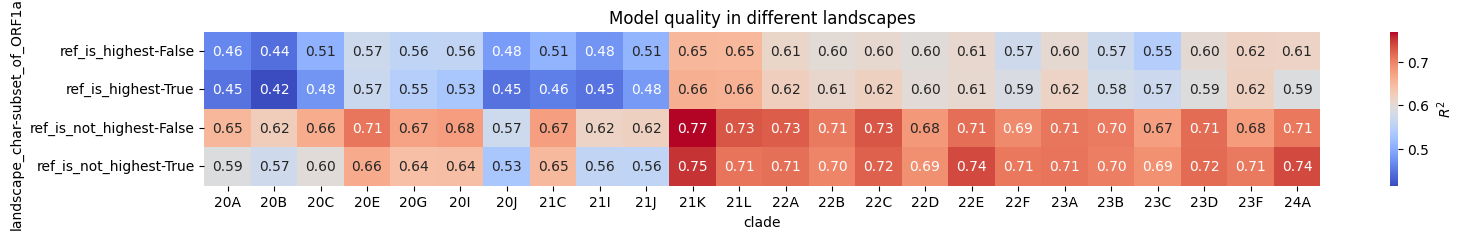

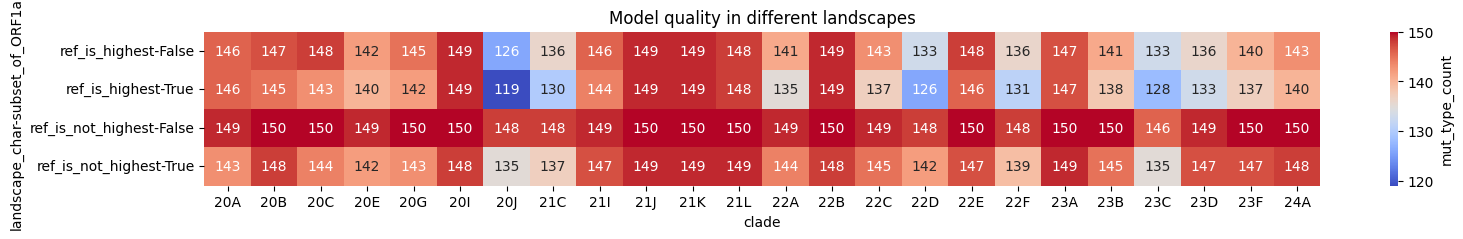

In [73]:
plt.figure(figsize=(18, 2))
_ = data_fitness_sites_df.pivot(columns='clade', index=['landscape_char', 'subset_of_ORF1ab'], values='r2')
sns.heatmap(_, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': '$R^2$'})
plt.title('Model quality in different landscapes')
plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(18, 2))
_ = data_fitness_sites_df.pivot(columns='clade', index=['landscape_char', 'subset_of_ORF1ab'], values='mut_type_count')
sns.heatmap(_, annot=True, fmt='.0f', cmap='coolwarm', cbar_kws={'label': 'mut_type_count'})
plt.title('Model quality in different landscapes')
plt.yticks(rotation=0)
plt.show()

/tmp/ipykernel_62778/1340716598.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Ранние клады', 'Поздние клады\n(Омикрон+)'], fontsize=12)


[Text(0, 0, 'Ранние клады'), Text(1, 0, 'Поздние клады\n(Омикрон+)')]

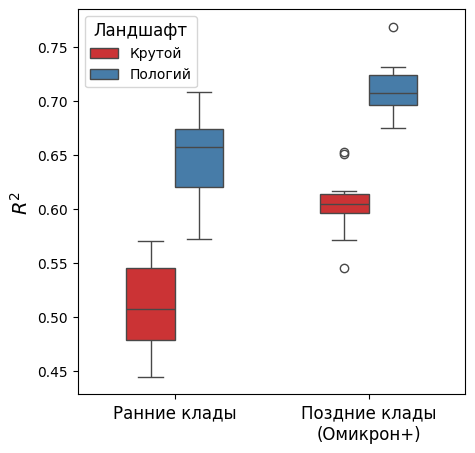

In [ ]:
# only for subset_of_ORF1ab == False, i.e. all genes without dublicates

plt.figure(figsize=(5, 5))
_ = data_fitness_sites_df.query('subset_of_ORF1ab == False').copy()
_['landscape_char'] = _.landscape_char.map({'ref_is_highest': 'Крутой', 
                                            'ref_is_not_highest': 'Пологий'})
ax = sns.boxplot(
    data=_, width=0.5,
    order=sorted(data_fitness_sites_df['time_period'].unique()),
    hue='landscape_char', y='r2', x='time_period', palette='Set1',
)
plt.ylabel('$R^2$', fontsize=14)
plt.xlabel('')
plt.legend(title='Ландшафт', fontsize=10, title_fontsize=12)
ax.set_xticklabels(['Ранние клады', 'Поздние клады\n(Омикрон+)'], fontsize=12)

In [100]:
_ = data_fitness_sites_df.query('time_period == "Early clades"')
pg.pairwise_tests(_, dv='r2', within='landscape_char', subject='clade',)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,landscape_char,ref_is_highest,ref_is_not_highest,True,True,-12.652787,9.0,two-sided,4.897619e-07,2.876e+04,-2.797154


In [101]:
_ = data_fitness_sites_df.query('time_period != "Early clades"')
pg.pairwise_tests(_, dv='r2', within='landscape_char', subject='clade')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,landscape_char,ref_is_highest,ref_is_not_highest,True,True,-20.735191,13.0,two-sided,2.407462e-11,2.801e+08,-4.292216


### plot distance to equilibrium in different landscapes

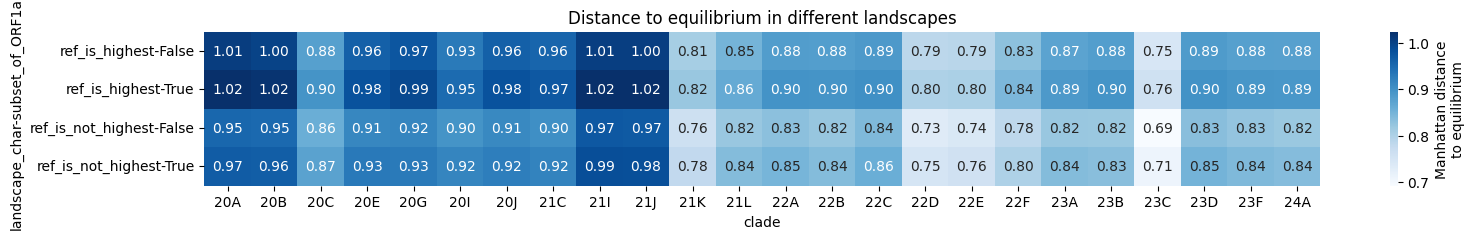

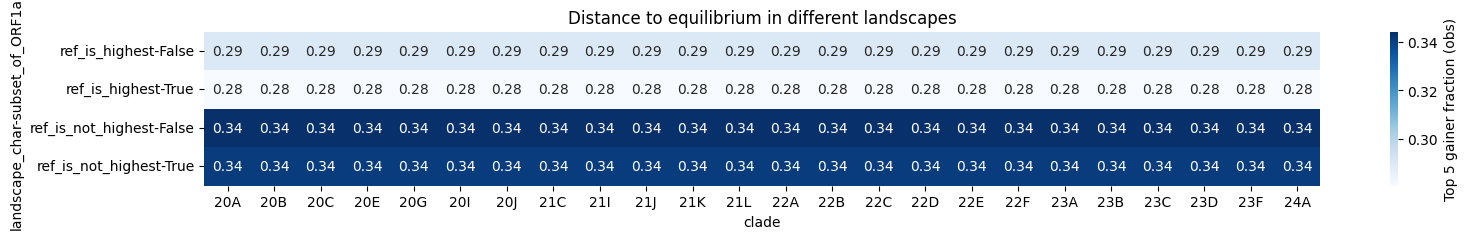

In [ ]:
plt.figure(figsize=(18, 2))
_ = d_to_eq_df.pivot(index=['landscape_char', 'subset_of_ORF1ab'], columns='clade', values='cityblock')
sns.heatmap(_, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Manhattan distance\nto equilibrium'})
plt.title('Distance to equilibrium in different landscapes')
plt.yticks(rotation=0)
plt.show()

/tmp/ipykernel_62778/172347156.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Ранние клады', 'Поздние клады\n(Омикрон+)'], fontsize=12)


[Text(0, 0, 'Ранние клады'), Text(1, 0, 'Поздние клады\n(Омикрон+)')]

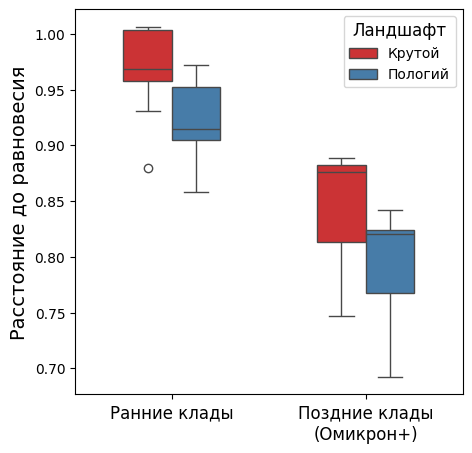

In [77]:
plt.figure(figsize=(5, 5))
_ = d_to_eq_df.query('subset_of_ORF1ab == False').copy()
_['landscape_char'] = _.landscape_char.map({'ref_is_highest': 'Крутой', 
                                            'ref_is_not_highest': 'Пологий'})
ax = sns.boxplot(
    data=_, width=0.5,
    order=sorted(d_to_eq_df['time_period'].unique()),
    hue='landscape_char', y='cityblock', x='time_period', palette='Set1',
)
plt.ylabel('Расстояние до равновесия', fontsize=14)
plt.xlabel('')
plt.legend(title='Ландшафт', fontsize=10, title_fontsize=12)
ax.set_xticklabels(['Ранние клады', 'Поздние клады\n(Омикрон+)'], fontsize=12)

In [ ]:
# top5 gainer fraction 29% and 34%
_ = d_to_eq_df.query('clade == "20A"')
_

,clade,landscape_char,subset_of_ORF1ab,cityblock,euclidean,top5_gainer_frac_eq,top5_gainer_frac_obs,time_period
0,20A,ref_is_highest,False,1.006171,0.327179,0.792281,0.289436,Early clades
1,20A,ref_is_highest,True,1.023830,0.332449,0.792281,0.280365,Early clades
2,20A,ref_is_not_highest,False,0.953074,0.340430,0.792281,0.344431,Early clades
3,20A,ref_is_not_highest,True,0.967248,0.348053,0.792281,0.341279,Early clades


In [99]:
_ = d_to_eq_df.query('time_period == "Early clades"')
pg.pairwise_tests(_, dv='cityblock', within='landscape_char', subject='clade',)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,landscape_char,ref_is_highest,ref_is_not_highest,True,True,11.4085,9.0,two-sided,0.000001,1.328e+04,1.125327


In [98]:
_ = d_to_eq_df.query('time_period != "Early clades"')
pg.pairwise_tests(_, dv='cityblock', within='landscape_char', subject='clade')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,landscape_char,ref_is_highest,ref_is_not_highest,True,True,21.924807,13.0,two-sided,1.187892e-11,5.36e+08,1.031209


In [93]:
pg.homoscedasticity(d_to_eq_df.query('subset_of_ORF1ab == False'), dv='cityblock', group='landscape_char')

,W,pval,equal_var
levene,0.043226,0.836217,True


In [ ]:
pg.normality(d_to_eq_df, dv='cityblock', group='landscape_char')

,W,pval,normal
landscape_char,,,
ref_is_highest,0.937672,0.144731,True
ref_is_not_highest,0.956887,0.379126,True


In [ ]:
pg.normality(d_to_eq_df, dv='cityblock', group='time_period')

,W,pval,normal
time_period,,,
Late clades\n(Omicron+),0.926596,0.050623,True
Early clades,0.949254,0.355909,True


In [ ]:
pg.anova(d_to_eq_df, dv='cityblock', between='time_period')

,Source,ddof1,ddof2,F,p-unc,np2
0,time_period,1,46,74.685793,3.406726e-11,0.618845


In [ ]:
pg.rm_anova(d_to_eq_df, dv='cityblock', within='landscape_char', subject='clade')

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,landscape_char,1,23,532.206642,2.105901e-17,0.097488,1.0


In [ ]:
pg.pairwise_tests(d_to_eq_df, dv='cityblock', within='landscape_char', subject='clade', between='time_period')

,Contrast,landscape_char,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,landscape_char,-,ref_is_highest,ref_is_not_highest,True,True,23.069604,23.000000,two-sided,2.105901e-17,2.084e+14,0.632935
1,time_period,-,Early clades,Late clades\n(Omicron+),False,True,7.231257,21.538720,two-sided,3.436688e-07,3.259e+04,2.790286
2,landscape_char * time_period,ref_is_highest,Early clades,Late clades\n(Omicron+),False,True,6.797886,21.106203,two-sided,9.823604e-07,1.38e+04,2.649046
3,landscape_char * time_period,ref_is_not_highest,Early clades,Late clades\n(Omicron+),False,True,7.577115,21.790801,two-sided,1.529120e-07,6.393e+04,2.900797


### AA delta_fitness AND AA fitness 

In [247]:
fast_sites = pd.read_csv('./data/ref_sites_rates_cat4.csv', index_col=0).query('rate_cat == 4').index.values
fast_sites

array([  274,   275,   278, ..., 29666, 29668, 29670], shape=(4951,))

In [248]:
X_descr

min      max      mean   median       std  count  max=0  \
gene aa_site                                                               
E    1       -7.1032 -3.15600 -4.558900 -4.20155  1.412269      6   True   
     2       -5.1893 -2.27390 -3.369967 -3.16075  0.991358      6   True   
     3       -2.4956 -0.76330 -1.350945 -1.07244  0.782417      4   True   
     4       -3.1612 -0.36699 -2.383348 -2.82070  1.099300      6   True   
     5       -3.5840  0.72401 -1.498047 -2.14025  1.698920      6  False   
...              ...      ...       ...      ...       ...    ...    ...   
nsp9 109     -5.1893  1.11350 -2.792800 -3.35530  2.174497      6  False   
     110     -5.1071 -1.46820 -2.825300 -2.48540  1.395265      5   True   
     111     -7.2405 -1.89070 -4.397983 -4.42670  1.752579      6   True   
     112     -5.0843 -0.80668 -2.522769 -2.44460  1.528106      7   True   
     113     -5.1893 -0.81593 -2.809438 -2.64880  1.468441      6   True   

                  landscape_char  
gene aa_site                      
E    1            ref_is_highest  
     2            ref_is_highest  
     3            ref_is_highest  
     4            ref_is_highest  
     5        ref_is_not_highest  
...                          ...  
nsp9 109      ref_is_not_highest  
     110          ref_is_highest  
     111          ref_is_highest  
     112          ref_is_highest  
     113          ref_is_highest  

[16764 rows x 8 columns]

In [ ]:
data_fitness_sites = []
for clade in clades_mut_cnt[clades_mut_cnt>100000].index:
    print(clade)
    spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

    spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
    df_changes = collect_possible_changes(1, spectrum_dct)
    exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
        .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

    for lchar in aamut_fitness_ns_lbl.landscape_char.unique():
        print(lchar, end=' ')

        cur_aa_freqs_dct = X_descr.query(f'landscape_char == "{lchar}"')[['landscape_char']]\
            .join(aa_fitness_ref[['aa']]).aa.value_counts().rename(index=amino_acid_codes).to_dict()

        cur_aamut = aamut_fitness_ns_lbl\
            .query(f'clade == "{clade}" & actual_count > 0 & landscape_char == "{lchar}"')\
                .rename(columns={'actual_count': 'count'})
        
        cur_aamut_low_df  = cur_aamut.query('delta_fitness < 0')
        cur_aamut_high_df = cur_aamut.query('delta_fitness >= 0')

        for cur_sample, label in zip([cur_aamut, cur_aamut_low_df, cur_aamut_high_df], 
                                     ['any', 'Δfitness<0', 'Δfitness>0']):

            aas = prepare_aa_subst(cur_sample, exp_aa_subst_cur, cur_aa_freqs_dct)
            cur_met = calc_metrics(aas)
            data_fitness_sites.append({
                'clade': clade,
                'landscape_char': lchar,
                'df_sample': label, 
                'r2': cur_met['r2'], 
                'spearman_corr': cur_met['spearman_corr'], 
                'mut_count': cur_met['mut_count'], 
                'mut_type_count': aas.nobs.ne(0).sum(), 
            })
    print()

data_fitness_sites_df = pd.DataFrame(data_fitness_sites)
data_fitness_sites_df.to_csv('./data/metrics_landscapes_and_df.csv', index=False)

20A
ref_is_highest ref_is_not_highest 
24A
ref_is_highest ref_is_not_highest 
21I
ref_is_highest ref_is_not_highest 
23A
ref_is_highest ref_is_not_highest 
22E
ref_is_highest ref_is_not_highest 
20I
ref_is_highest ref_is_not_highest 
21L
ref_is_highest ref_is_not_highest 
22B
ref_is_highest ref_is_not_highest 
21K
ref_is_highest ref_is_not_highest 
21J
ref_is_highest ref_is_not_highest 


In [112]:
data_fitness_sites_df.head()

,clade,landscape_char,df_sample,r2,spearman_corr,mut_count,mut_type_count
0,20A,ref_is_highest,any,0.457175,0.804500,26213.0,146
1,20A,ref_is_highest,Δfitness<0,0.581366,0.877995,17669.0,71
2,20A,ref_is_highest,Δfitness>0,-0.226992,0.392497,8544.0,136
3,20A,ref_is_not_highest,any,0.639564,0.819285,77229.0,149
4,20A,ref_is_not_highest,Δfitness<0,0.624500,0.879572,15649.0,71


In [151]:
top_clades = data_fitness_sites_df.query('df_sample == "Δfitness<0" & mut_type_count > 120').clade.unique()

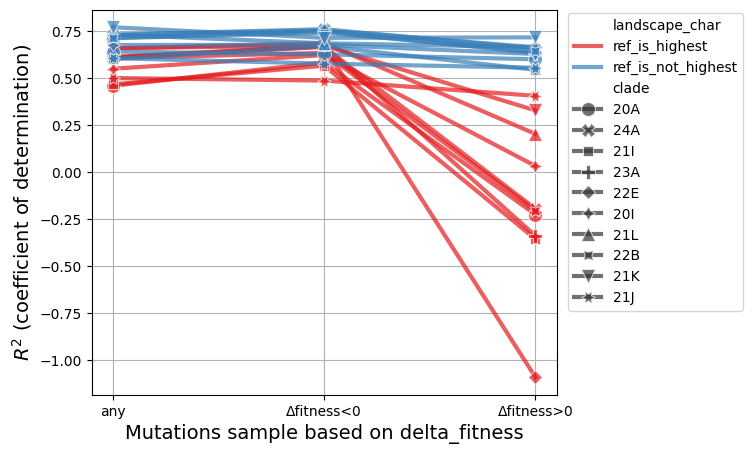

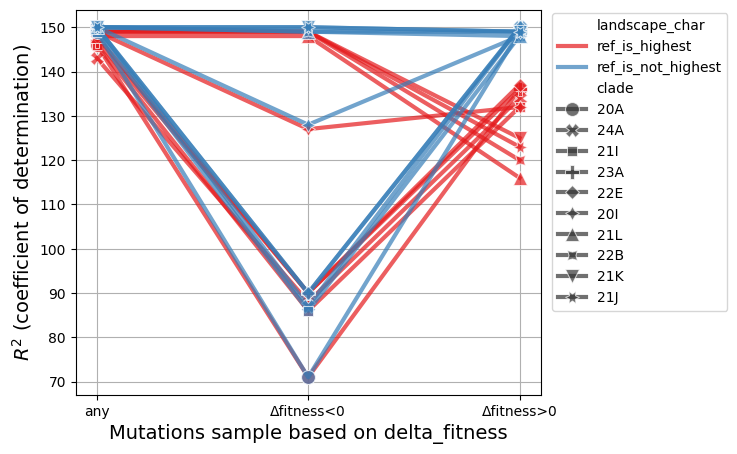

In [ ]:
plt.figure(figsize=(6, 5))
ax = sns.lineplot(
    data_fitness_sites_df, hue='landscape_char', y='r2', style='clade', x='df_sample', 
    markers=True, dashes=False, palette='Set1', alpha=0.7,
    linewidth=3, markersize=10, 
    # style_order=top_clades,
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
# ax.set_xticks(range(1, 5))
ax.set_ylabel('$R^2$ (coefficient of determination)', fontsize=14)
ax.set_xlabel('Mutations sample based on delta_fitness', fontsize=14)

plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
# plt.grid(axis='y', alpha=0.7)
# plt.xticks(fontsize=14)
plt.show()

plt.figure(figsize=(6, 5))
ax = sns.lineplot(
    data_fitness_sites_df, hue='landscape_char', y='mut_type_count', style='clade', x='df_sample', 
    markers=True, dashes=False, palette='Set1', alpha=0.7,
    linewidth=3, markersize=10, 
    # style_order=top_clades,
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
# ax.set_xticks(range(1, 5))
ax.set_xlabel('Mutations sample based on delta_fitness', fontsize=14)

plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
# plt.grid(axis='y', alpha=0.7)
# plt.xticks(fontsize=14)
plt.show()

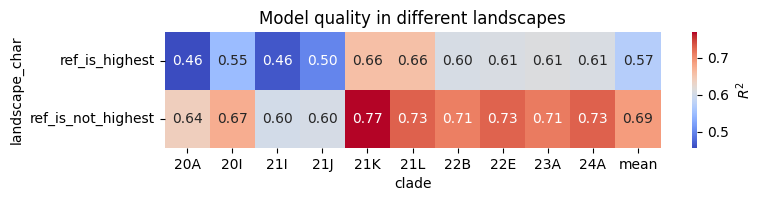

In [106]:
plt.figure(figsize=(8, 1.5))
_ = data_fitness_sites_df.pivot(columns='clade', index='landscape_char', values='r2')
_['mean'] = _.mean(axis=1)

sns.heatmap(_, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': '$R^2$'})
plt.title('Model quality in different landscapes')
plt.yticks(rotation=0);